## Load Libraries and Datasets

In [19]:
# %pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install transformers[torch]==4.30.2
# %pip install accelerate -U
# %pip install optuna
# %pip install ipywidgets
# %pip install ipywidgets-multiselect

In [20]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer

In [21]:
import pandas as pd

# Dictionary of dataset names and file paths
dataset_files = {
    "combined_123": "Dataset/Pre-Processed Dataset/combined_123.csv",
    "combined_1234": "Dataset/Pre-Processed Dataset/combined_1234.csv",
    "dataset_1_Cyberbullying_Bahasa_Indonesia": "Dataset/Pre-Processed Dataset/dataset_1_Cyberbullying_Bahasa_Indonesia-Kaggle-CitaTiaraHanni.csv",
    "dataset_2_cyberbullying_dataset": "Dataset/Pre-Processed Dataset/dataset_2_cyberbullying_dataset-Huggingface-aditdwi123.csv",
    "dataset_3_dataset_komentar_instagram_cyberbullying": "Dataset/Pre-Processed Dataset/dataset_3_dataset_komentar_instagram_cyberbullying-github-rizalespe.csv",
    "dataset_4_dataset_luqyana": "Dataset/Pre-Processed Dataset/dataset_4_dataset_luqyana.csv",
    "combined_123_sastrawi": "Dataset/Pre-Processed Dataset/pySastrawi/combined_123_sastrawi.csv",
    "combined_1234_sastrawi": "Dataset/Pre-Processed Dataset/pySastrawi/combined_1234_sastrawi.csv",
    "combined_123_stopword": "Dataset/Pre-Processed Dataset/without-stopword/combined_123_stopword.csv",
    "combined_1234_stopword": "Dataset/Pre-Processed Dataset/without-stopword/combined_1234_stopword.csv",
}

# Load datasets into a dictionary
datasets = {
    name: pd.read_csv(path)[["encoded_label", "clean_text"]]
    for name, path in dataset_files.items()
}

# Example: show first 10 rows of combined_dataset
datasets["combined_1234"].head(10)

,encoded_label,clean_text
0,1,kaka tidur yaa sudah pagi tidak boleh capek2
1,1,makan nasi padang saja badannya
2,0,suka cukur jembut manggung
3,1,hai kak isyana ngefans sekali kak isyana suka ...
4,1,manusia bidadari sih herann deh cantik
5,0,<USERNAME> kinantii isyan sekarang berubah ya ...
6,1,gemesnya isyan mirip tango berlapis lapis ciaaaa
7,0,jelek saja anaknya ayahnya cakep2
8,0,anaknya mirip sudah tua begitu ya mukanya kart...
9,0,muka anak nya ko tua sekali yaa tidak ngegemes...


                                           Dataset  Samples  Positive (%)  Avg Text Length  Median Text Length
                                      combined_123     2066     45.014521        73.882381                53.0
                                     combined_1234     3435     46.724891        77.289374                56.0
          dataset_1_Cyberbullying_Bahasa_Indonesia      650     50.000000        49.004615                43.0
                   dataset_2_cyberbullying_dataset     1019     39.744848        72.024534                50.0
dataset_3_dataset_komentar_instagram_cyberbullying      397     50.377834       119.382872                96.0
                         dataset_4_dataset_luqyana     1369     49.306063        82.430972                61.0
                             combined_123_sastrawi     2066     45.014521        56.330106                41.0
                            combined_1234_sastrawi     3435     46.724891        58.606405                43.0
 

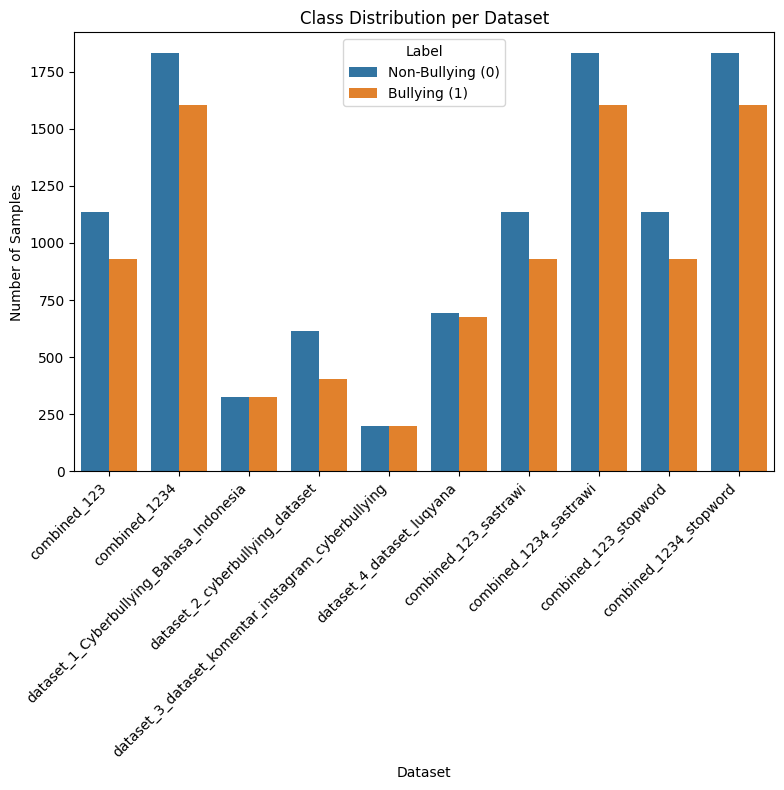

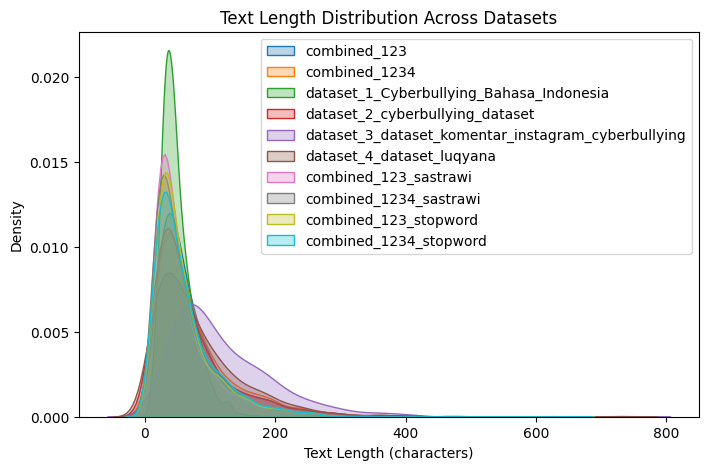


📋 Sample examples from dataset_4_dataset_luqyana:


,encoded_label,clean_text
427,0,tidak button dislike kalau opsi jari saya kasi...
1087,0,username bilang itu kuin kamu gesek grepe ama ...
668,0,anak keras kepala mimi nya ulta tidak datang s...
572,1,<USERNAME> semangat ya tidak usah peduliin omo...
115,1,<USERNAME> pansos


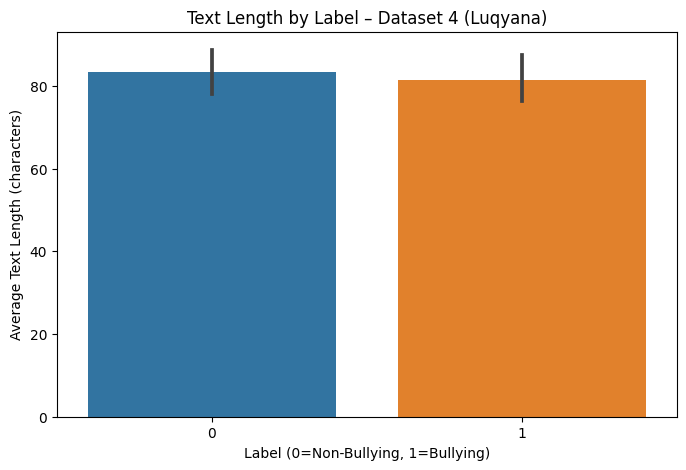


📋 Top words in combined_123:
Top words (label 0): [('kamu', 396), ('tidak', 395), ('yang', 269), ('anjing', 264), ('orang', 230), ('saja', 212), ('nya', 188), ('sudah', 172), ('ya', 155), ('username', 143)]
Top words (label 1): [('yang', 256), ('tidak', 235), ('cantik', 136), ('ya', 121), ('semoga', 111), ('sekali', 107), ('kalau', 103), ('nya', 99), ('saja', 95), ('sudah', 91)]

📋 Top words in combined_1234:
Top words (label 0): [('tidak', 667), ('kamu', 581), ('yang', 466), ('orang', 378), ('saja', 353), ('nya', 327), ('username', 298), ('sudah', 277), ('anjing', 274), ('ya', 267)]
Top words (label 1): [('yang', 534), ('tidak', 462), ('username', 235), ('ya', 232), ('cantik', 229), ('nya', 215), ('kalau', 203), ('saja', 187), ('sudah', 186), ('semoga', 178)]

📋 Top words in dataset_1_Cyberbullying_Bahasa_Indonesia:
Top words (label 0): [('kamu', 109), ('tidak', 79), ('anjing', 53), ('saja', 48), ('muka', 47), ('sudah', 43), ('nya', 34), ('ya', 33), ('kek', 28), ('orang', 27)]
Top wo

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Basic info summary
summary = []
for name, df in datasets.items():
    summary.append({
        "Dataset": name,
        "Samples": len(df),
        "Positive (%)": 100 * df["encoded_label"].mean(),
        "Avg Text Length": np.mean(df["clean_text"].astype(str).apply(len)),
        "Median Text Length": np.median(df["clean_text"].astype(str).apply(len))
    })
summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

# Basic info summary
summary = []
for name, df in datasets.items():
    summary.append({
        "Dataset": name,
        "Samples": len(df),
        "Positive (%)": 100 * df["encoded_label"].mean(),
        "Avg Text Length": np.mean(df["clean_text"].astype(str).apply(len)),
        "Median Text Length": np.median(df["clean_text"].astype(str).apply(len))
    })

class_counts = []
for name, df in datasets.items():
    counts = df["encoded_label"].value_counts().to_dict()
    class_counts.append({
        "Dataset": name,
        "Non-Bullying (0)": counts.get(0, 0),
        "Bullying (1)": counts.get(1, 0)
    })

class_counts_df = pd.DataFrame(class_counts)
class_counts_melted = class_counts_df.melt(id_vars="Dataset", var_name="Label", value_name="Count")

plt.figure(figsize=(8, 8))
sns.barplot(data=class_counts_melted, x="Dataset", y="Count", hue="Label")
plt.title("Class Distribution per Dataset")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.xlabel("Dataset")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


# --- 2️⃣ Text length distribution ---
plt.figure(figsize=(8, 5))
for name, df in datasets.items():
    lengths = df["clean_text"].astype(str).apply(len)
    sns.kdeplot(lengths, label=name, fill=True, alpha=0.3)
plt.title("Text Length Distribution Across Datasets")
plt.xlabel("Text Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- 3️⃣ Example texts ---
print("\n📋 Sample examples from dataset_4_dataset_luqyana:")
display(datasets["dataset_4_dataset_luqyana"].sample(5, random_state=42))


plt.figure(figsize=(8,5))
sns.barplot(data=datasets["dataset_4_dataset_luqyana"],
            x="encoded_label", 
            y=datasets["dataset_4_dataset_luqyana"]["clean_text"].astype(str).apply(len))
plt.title("Text Length by Label – Dataset 4 (Luqyana)")
plt.xlabel("Label (0=Non-Bullying, 1=Bullying)")
plt.ylabel("Average Text Length (characters)")
plt.show()

from collections import Counter
import re

def get_common_words(df, label, top_n=10):
    texts = " ".join(df[df["encoded_label"] == label]["clean_text"].astype(str).tolist())
    words = re.findall(r'\w+', texts.lower())
    return Counter(words).most_common(top_n)

for dataset in datasets.keys():
    print(f"\n📋 Top words in {dataset}:")
    print("Top words (label 0):", get_common_words(datasets[dataset], 0))
    print("Top words (label 1):", get_common_words(datasets[dataset], 1))




## Options

In [23]:
import ipywidgets as widgets
from ipywidgets import SelectMultiple
from IPython.display import display

In [48]:
import ipywidgets as widgets
from IPython.display import display

bert_model_path = 'indolem/indobert-base-uncased'
distilbert_model_path = 'cahya/distilbert-base-indonesian'

import torch
from transformers import BertModel, DistilBertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn

class BertMeanPoolingForSequenceClassification(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        last_hidden_state = outputs.last_hidden_state  # [batch, seq, hidden]
        
        # mask padding tokens before mean pooling
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        summed = torch.sum(last_hidden_state * mask, dim=1)
        summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
        mean_pooled = summed / summed_mask
        
        logits = self.classifier(self.dropout(mean_pooled))

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)
    
class DistilBertMeanPoolingForSequenceClassification(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        last_hidden_state = outputs.last_hidden_state
        
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        summed = torch.sum(last_hidden_state * mask, dim=1)
        summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
        mean_pooled = summed / summed_mask
        
        logits = self.classifier(self.dropout(mean_pooled))

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)



# 0 = distilbert, 1 = bert
model_choice_int = widgets.Dropdown(
    options=[('Distilbert', 0), ('Indobert', 1), ('MeanDistilbert', 2), ('MeanIndobert', 3)],
    value=1,
    description='Model:',
    disabled=False,
)

optuna_trials = widgets.BoundedIntText(
    value=30,
    min=0,
    # max=50,
    step=1,
    description='optuna_trials:',
    disabled=False
)

dataset_selector = widgets.SelectMultiple(
    options=list(datasets.keys()),  # all dataset names
    description='Datasets:',
    disabled=False
)

use_pruning_checkbox = widgets.Checkbox(
    value=True,  # default ON
    description='Use Pruning',
    disabled=False
)

use_early_stopping_checkbox = widgets.Checkbox(
    value=True,  # default ON
    description='Use Early Stopping',
    disabled=False
)

use_stratify = widgets.Checkbox(
    value=False,  # default ON
    description='Use Stratify',
    disabled=False
)

use_freeze_encoder = widgets.Checkbox(
    value=False,  # default OFF
    description='Freeze Encoder Layers',
    disabled=False
)

use_dropout_tuning = widgets.Checkbox(
    value=False,
    description="Tune Dropout",
    icon="sliders-h"
)

use_warmup_steps = widgets.Checkbox(
    value=False,
    description="Warmup Steps",
    icon="sliders-h"
)

use_scheduler_tuning = widgets.Checkbox(
    value=True,
    description="Tune LR scheduler type",
    style={'description_width': 'initial'}
    
)

display(
    model_choice_int,
    optuna_trials,
    dataset_selector,
    # use_pruning_checkbox,
    # use_early_stopping_checkbox,
    use_stratify,
    use_freeze_encoder,
    use_dropout_tuning,
    use_warmup_steps,
    use_scheduler_tuning
)


Dropdown(description='Model:', index=1, options=(('Distilbert', 0), ('Indobert', 1), ('MeanDistilbert', 2), ('…

BoundedIntText(value=30, description='optuna_trials:')

SelectMultiple(description='Datasets:', options=('combined_123', 'combined_1234', 'dataset_1_Cyberbullying_Bah…

Checkbox(value=False, description='Use Stratify')

Checkbox(value=False, description='Freeze Encoder Layers')

Checkbox(value=False, description='Tune Dropout')

Checkbox(value=False, description='Warmup Steps')

Checkbox(value=True, description='Tune LR scheduler type', style=DescriptionStyle(description_width='initial')…

## Train-Test Split

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

# Load tokenizer
if model_choice_int.value == 0:
    tokenizer = AutoTokenizer.from_pretrained(distilbert_model_path)
    
else:
    tokenizer = AutoTokenizer.from_pretrained(bert_model_path)
    
from collections import Counter
from transformers import DataCollatorWithPadding
import numpy as np

from sklearn.model_selection import train_test_split

def encode_selected_datasets(selected_datasets=None, val_size=0.1, test_size=0.2):
    """
    Returns: (train_val_test_dataset_dict, combo_name)
    train_val_test_dataset_dict = {"train": train_dataset, "val": val_dataset, "test": test_dataset, "collator": data_collator}
    """
    # --- Normalize selection ---
    val = selected_datasets if selected_datasets is not None else dataset_selector.value
    if isinstance(val, str):
        selected = [val]
    elif val is None:
        selected = []
    else:
        selected = list(val)

    if len(selected) == 0:
        raise ValueError("No datasets selected. Please select at least one dataset.")

    missing = [s for s in selected if s not in datasets]
    if missing:
        raise KeyError(f"Selected dataset(s) not found in `datasets`: {missing}")

    combo_name = selected[0] if len(selected) == 1 else "+".join(selected)

    # --- Merge dataframes ---
    if len(selected) == 1:
        df = datasets[selected[0]].copy()
    else:
        df = pd.concat([datasets[name].copy() for name in selected], ignore_index=True)

    if 'clean_text' not in df.columns or 'encoded_label' not in df.columns:
        raise ValueError(f"Dataset {combo_name} missing required columns 'clean_text' and/or 'encoded_label'.")

    X = df['clean_text'].tolist()
    y = df['encoded_label'].tolist()

    label_counts = Counter(y)

    if use_stratify.value:
        can_stratify = (len(label_counts) >= 2) and (min(label_counts.values()) >= 2)
    else:
        can_stratify = False

    print("Stratify: ", can_stratify)

    # --- First split train+val vs test ---
    stratify = y if can_stratify else None
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify
    )

    # --- Split temp into train and val ---
    stratify_temp = y_temp if can_stratify else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42, stratify=stratify_temp
    )

    print(f"Selected: {selected}")
    print(f"Combo name: {combo_name}")
    print("Label distribution (combined):", dict(label_counts))
    print("Train/val/test sizes:", len(X_train), len(X_val), len(X_test))

    # --- Tokenize ---
    def tokenize_texts(texts):
        # Ensure all inputs are strings, replace NaN/None, strip whitespace
        clean_texts = [str(t) if not isinstance(t, float) and t is not None else "" for t in texts]
        clean_texts = [t.strip() for t in clean_texts]

        return tokenizer(
            clean_texts,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_attention_mask=True,
        )



    train_dataset = CustomDataset(tokenize_texts(X_train), y_train)
    val_dataset   = CustomDataset(tokenize_texts(X_val),   y_val)
    test_dataset  = CustomDataset(tokenize_texts(X_test),  y_test)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    return {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset,
        "collator": data_collator,
    }, combo_name


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Train and Evaluation


In [27]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [28]:
output_dir = f'./results/{dataset_selector.value}_{"distilbert" if model_choice_int.value == 0 else "bert"}'
log_dir = f'./logs/{dataset_selector.value}_{"distilbert" if model_choice_int.value == 0 else "bert"}'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

default_training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=f'training_{dataset_selector.value}_{"distilbert" if model_choice_int.value == 0 else "bert"}',
    
    # Training setup
    num_train_epochs=3,               # conservative, prevents overfitting on small datasets
    per_device_train_batch_size=16,   # reasonable for most GPUs
    per_device_eval_batch_size=32,    # eval can use larger batch
    learning_rate=5e-5,               # good default for BERT/DistilBERT
    
    # Optimizer & regularization
    weight_decay=0.01,
    warmup_ratio=0.06,                # scale warmup to dataset size instead of fixed steps
    lr_scheduler_type="linear",
    optim="adamw_torch",
    
    # Logging
    logging_dir=log_dir,
    logging_steps=20,
    evaluation_strategy="epoch",      # eval once per epoch
    do_eval=True,
    
    # No saving (you said you’ll only keep best params)
    save_strategy="no",
    
    # Misc
    report_to=[],                     # no wandb/tensorboard unless needed
    fp16=True                         # faster if GPU supports it
)

best_training_args_distil = TrainingArguments(
    output_dir=output_dir,
    run_name=f'training_{dataset_selector.value}_{"distilbert" if model_choice_int.value == 0 else "bert"}',
    per_device_eval_batch_size=16,  # can stay as-is for evaluation
    num_train_epochs=6,            # ⬅️ from Optuna
    per_device_train_batch_size=16,  # ⬅️ from Optuna
    warmup_steps=29,               # ⬅️ from Optuna
    weight_decay=0.09793901282245424,  # ⬅️ from Optuna
    learning_rate=3.694163912198525e-05,  # ⬅️ from Optuna
    logging_dir=log_dir,
    logging_steps=10,
    do_eval=True,
    eval_steps=500,
    save_strategy="epoch",
    save_total_limit=1,
    report_to=[],
    fp16=True,
    optim="adamw_torch"
)

best_training_args_bert = TrainingArguments(
    output_dir=output_dir,
    run_name=f'training_{dataset_selector.value}_{"distilbert" if model_choice_int.value == 0 else "bert"}',
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,  # From Optuna
    num_train_epochs=7,             # From Optuna
    warmup_steps=164,               # From Optuna
    weight_decay=0.028,  # From Optuna
    learning_rate=7.83e-05,  # From Optuna
    logging_dir=log_dir,
    logging_steps=10,
    do_eval=True,
    eval_steps=500,
    save_strategy="epoch",
    save_total_limit=1,
    report_to=[],
    fp16=True,
    optim="adamw_torch"
)


### Default


In [29]:
os.environ["WANDB_MODE"] = "disabled"

In [30]:
def evaluate_model(model, test_dataset, batch_size, output_dir, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataloader = DataLoader(test_dataset, batch_size=batch_size)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Move to CPU and accumulate
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().astype(int))

    # Metrics
    report = classification_report(all_labels, all_preds, digits=4)
    print("classification_report:\n", report)
    with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.close()

    print(f"Evaluation complete for {dataset_name}")

In [31]:
import time
import numpy as np
import torch

from transformers import AutoConfig, Trainer, BertForSequenceClassification, DistilBertForSequenceClassification

def default_start_model_training_and_evaluation(model_choice=model_choice_int.value):
    dataset, name = encode_selected_datasets()
    print(f"\nTraining on dataset: {name}")
    print(f"Model: {model_choice_int.value}")

    # ✅ Always set config explicitly with num_labels=2
    if model_choice == 0:
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_path, config=config)
        training_args = best_training_args_distil

    elif model_choice == 1:
        config = AutoConfig.from_pretrained(bert_model_path, num_labels=2)
        model = BertForSequenceClassification.from_pretrained(bert_model_path, config=config)
        training_args = best_training_args_bert

    elif model_choice == 2:
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        model = DistilBertMeanPoolingForSequenceClassification(distilbert_model_path, config=config)
        training_args = default_training_args
        
    elif model_choice == 3:
        config = AutoConfig.from_pretrained(bert_model_path, num_labels=2)
        model = BertMeanPoolingForSequenceClassification(bert_model_path, config=config)
        training_args = default_training_args

    else:
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_path, config=config)
        training_args = default_training_args

    print(training_args)

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["val"],
    )

    trainer.train()

    # Save model (you said you only save best, but leaving here for completeness)
    trainer.save_model(output_dir)


    # Evaluate and log
    evaluate_model(model, dataset["test"], 4, output_dir, name)

    # 🔹 Inference time benchmarking
    print("\n⚡ Running inference speed benchmark...")
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # ✅ Use only a small subset of the test set for benchmarking
    benchmark_size = min(32, len(dataset["test"]))  # up to 32 samples
    subset_encodings = {
        "input_ids": torch.tensor(dataset["test"].encodings["input_ids"][:benchmark_size]).to(device),
        "attention_mask": torch.tensor(dataset["test"].encodings["attention_mask"][:benchmark_size]).to(device),
    }

    # Warm-up (GPU usually needs 1-2 warm passes for fair timing)
    with torch.no_grad():
        for _ in range(3):
            _ = model(**subset_encodings)

    # Benchmark
    n_runs = 50
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(**subset_encodings)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end = time.time()

    avg_time = (end - start) / n_runs
    samples_per_second = benchmark_size / avg_time

    print(f"🕒 Avg batch inference time: {avg_time:.4f} sec")
    print(f"📊 Throughput: {samples_per_second:.2f} samples/sec")


# default_start_model_training_and_evaluation(model_choice_int.value)

### Optuna

In [40]:
import torch
import numpy as np
from transformers import Trainer, DistilBertForSequenceClassification, BertForSequenceClassification
import gc
from torch.utils.data import DataLoader
from tqdm import tqdm
from optuna import create_study
import tempfile
from sklearn.metrics import f1_score
import tempfile
trial_dir = tempfile.mkdtemp(prefix="optuna_trial_")

output_dir_optuna = output_dir + '_optuna'

def optuna_hp_space(trial):
    space = {
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "warmup_steps": trial.suggest_int("warmup_steps", 0, 300),
        "freeze_layers": trial.suggest_categorical("freeze_layers", [0, 3, 6, 9]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
    }

    if use_warmup_steps.value:
        space["warmup_steps"] = trial.suggest_int("warmup_steps", 0, 300)
    else:
        space["warmup_steps"] = 0  # 🔒 fixed to 0 if disabled

    if use_dropout_tuning.value:  # ✅ only add if toggle is ON
        space["dropout"] = trial.suggest_float("dropout", 0.1, 0.5)
    else:
        space["dropout"] = 0.1  # default dropout

    # 🌀 Optional scheduler tuning
    if use_scheduler_tuning.value:
        space["lr_scheduler_type"] = trial.suggest_categorical("lr_scheduler_type", [
            "linear", "cosine", "cosine_with_restarts", "polynomial", "constant_with_warmup"
        ])
    else:
        space["lr_scheduler_type"] = "linear"

    return space

def manual_evaluate(model, dataset, batch_size=8, tokenizer=None):
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    device = next(model.parameters()).device


    collator = None
    if tokenizer is not None:
        from transformers import DataCollatorWithPadding
        collator = DataCollatorWithPadding(tokenizer=tokenizer)

    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Unique preds:", np.unique(all_preds))
    print("Unique labels:", np.unique(all_labels))

    f1 = f1_score(all_labels, all_preds)
    return f1

    

# Subclass Trainer to inject memory cleanup
class CleanTrainer(Trainer):
    def train(self, *args, **kwargs):
        result = super().train(*args, **kwargs)
        torch.cuda.empty_cache()
        gc.collect()
        return result

from transformers import AutoConfig

def get_model_and_args(choice, dropout=None):
    def apply_dropout(config):
        if dropout is not None:
            config.hidden_dropout_prob = dropout
            config.attention_probs_dropout_prob = dropout
        return config

    if choice == 0:  # DistilBERT CLS baseline
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        config = apply_dropout(config)
        return (
            lambda: DistilBertForSequenceClassification.from_pretrained(distilbert_model_path, config=config),
            best_training_args_distil
        )
    elif choice == 1:  # BERT CLS baseline
        config = AutoConfig.from_pretrained(bert_model_path, num_labels=2)
        config = apply_dropout(config)
        return (
            lambda: BertForSequenceClassification.from_pretrained(bert_model_path, config=config),
            best_training_args_bert
        )
    elif choice == 2:  # DistilBERT mean pooling
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        config = apply_dropout(config)
        return (
            lambda: DistilBertMeanPoolingForSequenceClassification(distilbert_model_path, config=config,),
            best_training_args_distil
        )
    elif choice == 3:  # BERT mean pooling
        config = AutoConfig.from_pretrained(bert_model_path, num_labels=2)
        config = apply_dropout(config)
        return (
            lambda: BertMeanPoolingForSequenceClassification(bert_model_path, config=config),
            best_training_args_bert
        )
    else:
        config = AutoConfig.from_pretrained(distilbert_model_path, num_labels=2)
        config = apply_dropout(config)
        return (
            lambda: DistilBertForSequenceClassification.from_pretrained(distilbert_model_path, config=config),
            default_training_args
        )


import optuna
from optuna.pruners import MedianPruner
from transformers import EarlyStoppingCallback
import shutil

# 🔧 config flags so you can turn them off easily

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1) if isinstance(p.predictions, np.ndarray) else np.argmax(p.predictions[0], axis=-1)
    return {"f1": f1_score(p.label_ids, preds)}


def objective(trial):
    dataset, name = encode_selected_datasets()
    hp = optuna_hp_space(trial)

    print(f"🎛 Scheduler tuning: {use_scheduler_tuning.value} | Using: {hp['lr_scheduler_type']}")
    print(f"🔥 Warmup steps ({use_warmup_steps.value}): {hp['warmup_steps']}")
    print(f"💧 Dropout: ({use_dropout_tuning.value}){hp['dropout']}")

    output_dir = './results'
    training_args = TrainingArguments(
        output_dir=os.path.join(tempfile.gettempdir(), f"optuna_trial_{trial.number}"),
        num_train_epochs=hp["num_train_epochs"],
        per_device_train_batch_size=hp["per_device_train_batch_size"],
        weight_decay=hp["weight_decay"],
        learning_rate=hp["learning_rate"],
        save_strategy="no",
        evaluation_strategy="no",
        logging_strategy="no",
        load_best_model_at_end=False,
        fp16=torch.cuda.is_available(),
        optim="adamw_torch",
        report_to=[]
    )
    
    model_init, base_args = get_model_and_args(model_choice_int.value, dropout=hp["dropout"])
    model = model_init()

    training_args = base_args
    training_args.learning_rate = hp["learning_rate"]
    training_args.num_train_epochs = hp["num_train_epochs"]
    training_args.per_device_train_batch_size = hp["per_device_train_batch_size"]
    training_args.weight_decay = hp["weight_decay"]
    training_args.warmup_steps = hp["warmup_steps"]
    training_args.lr_scheduler_type = hp["lr_scheduler_type"]

    if use_freeze_encoder.value:
        print("🧊 Freezing encoder layers...")
        if hasattr(model, "bert"):
            for param in model.bert.parameters():
                param.requires_grad = False
        elif hasattr(model, "distilbert"):
            for param in model.distilbert.parameters():
                param.requires_grad = False

        if hasattr(model, "bert"):
            encoder = model.bert.encoder.layer
        elif hasattr(model, "distilbert"):
            encoder = model.distilbert.transformer.layer
        else:
            encoder = None

        if encoder is not None:
            for layer in encoder[:hp["freeze_layers"]]:
                for param in layer.parameters():
                    param.requires_grad = False


    trainer = CleanTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["val"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    f1 = manual_evaluate(trainer.model, dataset["test"], batch_size=hp["per_device_train_batch_size"])

    # 🧹 Clean up after training
    del trainer, model
    torch.cuda.empty_cache()
    gc.collect()
    shutil.rmtree(training_args.output_dir, ignore_errors=True)

    import datetime

    # 📄 Append lightweight log entry
    log_path = "optuna_log.csv"
    header = not os.path.exists(log_path)

    # Write a separator at the start of a new Optuna run
    if trial.number == 0:
        with open(log_path, "a") as f:
            f.write("\n" + "#"*80 + "\n")
            f.write(f"# New Optuna Run | {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"# Dataset: {name}\n")
            f.write(f"# Model: {model_choice_int.value} | Freeze encoder: {use_freeze_encoder.value} | Dropout tuning: {use_dropout_tuning.value}\n")
            f.write("#"*80 + "\n")

    # Write header if first time
    if header:
        with open(log_path, "a") as f:
            f.write("trial,dataset,f1,learning_rate,batch_size,weight_decay,num_train_epochs,warmup_steps,dropout\n")

    # Log this trial’s results
    with open(log_path, "a") as f:
        f.write(f"{trial.number},{name},{f1:.4f},{hp['learning_rate']:.6f},{hp['per_device_train_batch_size']},"
                f"{hp['weight_decay']:.4f},{hp['num_train_epochs']},{hp['warmup_steps']},"
                f"{hp.get('dropout', 0.1):.2f}\n")

    # 🏁 Append best trial so far for readability
    try:
        study = trial.study
        best_trial = study.best_trial
        with open(log_path, "a") as f:
            f.write(f"# Best so far (dataset={name}): Trial {best_trial.number} | F1={best_trial.value:.4f}\n")
    except Exception:
        pass

    return f1



In [ ]:
import json
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from transformers import get_scheduler
from transformers import AdamW as HFAdamW   # HF's AdamW wrapper (or use torch.optim.AdamW)


def final_optuna_model(study, output_dir=f"./results/final_eval"):
    dataset, name = encode_selected_datasets()

    os.makedirs(output_dir, exist_ok=True)

    best_hp = study.best_trial.params

    with open(os.path.join(output_dir, "best_hyperparameters.json"), "w") as f:
        json.dump(best_hp, f, indent=4)

    # --- Handle scheduler (default to linear if not tuned)
    scheduler_type = best_hp.get("lr_scheduler_type", "linear")
    
    final_training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=best_hp["num_train_epochs"],
        per_device_train_batch_size=best_hp["per_device_train_batch_size"],
        learning_rate=best_hp["learning_rate"],
        weight_decay=best_hp["weight_decay"],
        warmup_steps=best_hp.get("warmup_steps", 0),
        lr_scheduler_type=scheduler_type,   # <- add this
        save_strategy="no",
        evaluation_strategy="no",
        load_best_model_at_end=False,
        logging_strategy="no",
        fp16=True,
        report_to=[]
    )




    model_init, _ = get_model_and_args(model_choice_int.value, dropout=best_hp["dropout"])
    final_model = model_init()

    tokenizer = AutoTokenizer.from_pretrained(
        distilbert_model_path if model_choice_int == 0 else bert_model_path
    )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    final_trainer = CleanTrainer(
        model=final_model,
        args=final_training_args,
        train_dataset=dataset["train"],
        data_collator=data_collator
    )

    # 5. Train
    train_result = final_trainer.train()

    # Save training logs (loss per epoch, etc.)
    with open(os.path.join(output_dir, "train_log.json"), "w") as f:
        json.dump(train_result.metrics, f, indent=4)

    # 6. Evaluate
    final_f1 = manual_evaluate(final_trainer.model, dataset["test"], batch_size=8, tokenizer=tokenizer)
    print(f"\n🎯 Final Test F1 Score (macro): {final_f1:.4f}")

    # Save metrics
    metrics = {
        "final_f1_macro": final_f1,
        "dataset_used": name,
    }
    with open(os.path.join(output_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)

    # Optional: get more detailed metrics
    y_true = dataset["test"].labels
    
    # Reuse the manual evaluation pipeline
    model = final_trainer.model
    model.eval()
    device = next(model.parameters()).device
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    dataloader = DataLoader(dataset["test"], batch_size=8, collate_fn=collator)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Final detailed eval"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = all_labels
    y_pred = all_preds


    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred).tolist()

    with open(os.path.join(output_dir, "classification_report.json"), "w") as f:
        json.dump(report, f, indent=4)
    with open(os.path.join(output_dir, "confusion_matrix.json"), "w") as f:
        json.dump(cm, f, indent=4)

    # 7. Save model + tokenizer
    final_trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Save Optuna study object for later inspection
    study.trials_dataframe().to_csv(os.path.join(output_dir, "optuna_trials.csv"), index=False)

    print(f"✅ Final model, tokenizer, hyperparameters, and metrics saved to {output_dir}")

    del final_model, final_trainer
    torch.cuda.empty_cache()
    gc.collect()

    shutil.rmtree(final_training_args.output_dir, ignore_errors=True)


def start_optuna():
    study = create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials.value)

    print("✅ Best trial:")
    print(study.best_trial)

    final_optuna_model(study, output_dir_optuna)


In [50]:
start_optuna()

[I 2025-11-12 21:30:29,457] A new study created in memory with name: no-name-d9d44a23-2482-4d52-a12b-e411d1af28b3
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 215
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/455 [00:00<?, ?it/s]

{'loss': 0.7291, 'learning_rate': 1.0130359375668591e-06, 'epoch': 0.11}
{'loss': 0.7139, 'learning_rate': 1.913512326515178e-06, 'epoch': 0.22}
{'loss': 0.697, 'learning_rate': 2.9265482640820373e-06, 'epoch': 0.33}
{'loss': 0.6973, 'learning_rate': 3.939584201648897e-06, 'epoch': 0.44}
{'loss': 0.6741, 'learning_rate': 5.065179687834295e-06, 'epoch': 0.55}
{'loss': 0.6952, 'learning_rate': 6.078215625401155e-06, 'epoch': 0.66}
{'loss': 0.6714, 'learning_rate': 7.203811111586553e-06, 'epoch': 0.77}
{'loss': 0.6783, 'learning_rate': 8.329406597771952e-06, 'epoch': 0.88}
{'loss': 0.6856, 'learning_rate': 9.45500208395735e-06, 'epoch': 0.99}
{'loss': 0.6815, 'learning_rate': 1.058059757014275e-05, 'epoch': 1.1}
{'loss': 0.679, 'learning_rate': 1.1706193056328149e-05, 'epoch': 1.21}
{'loss': 0.6451, 'learning_rate': 1.2831788542513547e-05, 'epoch': 1.32}
{'loss': 0.6373, 'learning_rate': 1.3957384028698948e-05, 'epoch': 1.43}
{'loss': 0.6073, 'learning_rate': 1.5082979514884346e-05, 'epoc

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 22.49it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:31:46,970] Trial 0 finished with value: 0.8976377952755904 and parameters: {'learning_rate': 2.4200302952986078e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.20246458785443827, 'num_train_epochs': 5, 'warmup_steps': 215, 'freeze_layers': 9, 'dropout': 0.3366301491364168, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.8976377952755904.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 209
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1086 [00:00<?, ?it/s]

{'loss': 0.7155, 'learning_rate': 3.3619080075329513e-06, 'epoch': 0.06}
{'loss': 0.6966, 'learning_rate': 7.144054516007521e-06, 'epoch': 0.11}
{'loss': 0.6903, 'learning_rate': 1.1346439525423711e-05, 'epoch': 0.17}
{'loss': 0.6965, 'learning_rate': 1.5128586033898282e-05, 'epoch': 0.22}
{'loss': 0.7221, 'learning_rate': 1.9330971043314472e-05, 'epoch': 0.28}
{'loss': 0.6554, 'learning_rate': 2.353335605273066e-05, 'epoch': 0.33}
{'loss': 0.6342, 'learning_rate': 2.7735741062146846e-05, 'epoch': 0.39}
{'loss': 0.7101, 'learning_rate': 3.193812607156304e-05, 'epoch': 0.44}
{'loss': 0.6278, 'learning_rate': 3.6140511080979224e-05, 'epoch': 0.5}
{'loss': 0.5694, 'learning_rate': 4.0342896090395416e-05, 'epoch': 0.55}
{'loss': 0.5798, 'learning_rate': 4.454528109981161e-05, 'epoch': 0.61}
{'loss': 0.5688, 'learning_rate': 4.874766610922779e-05, 'epoch': 0.66}
{'loss': 0.4588, 'learning_rate': 5.2950051118643985e-05, 'epoch': 0.72}
{'loss': 0.5053, 'learning_rate': 5.715243612806017e-05, 

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 38.75it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:33:47,588] Trial 1 finished with value: 0.8934010152284264 and parameters: {'learning_rate': 8.782984669679836e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.21289618611922206, 'num_train_epochs': 6, 'warmup_steps': 209, 'freeze_layers': 0, 'dropout': 0.254228217441567, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.8976377952755904.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 94
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7107, 'learning_rate': 1.70796569512955e-06, 'epoch': 0.22}
{'loss': 0.6932, 'learning_rate': 3.659926489563322e-06, 'epoch': 0.43}
{'loss': 0.7028, 'learning_rate': 6.099877482605536e-06, 'epoch': 0.65}
{'loss': 0.6927, 'learning_rate': 8.53982847564775e-06, 'epoch': 0.87}
{'loss': 0.6924, 'learning_rate': 1.0979779468689966e-05, 'epoch': 1.09}
{'loss': 0.6779, 'learning_rate': 1.341973046173218e-05, 'epoch': 1.3}
{'loss': 0.6487, 'learning_rate': 1.5859681454774396e-05, 'epoch': 1.52}
{'loss': 0.6338, 'learning_rate': 1.8299632447816606e-05, 'epoch': 1.74}
{'loss': 0.5811, 'learning_rate': 2.0739583440858823e-05, 'epoch': 1.96}
{'loss': 0.5313, 'learning_rate': 2.28641782741762e-05, 'epoch': 2.17}
{'loss': 0.4783, 'learning_rate': 2.2150567669970048e-05, 'epoch': 2.39}
{'loss': 0.4153, 'learning_rate': 2.14369570657639e-05, 'epoch': 2.61}
{'loss': 0.4075, 'learning_rate': 2.0723346461557748e-05, 'epoch': 2.83}
{'loss': 0.3577, 'learning_rate': 2.00097358573516e-05, 'epoch'

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.11it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:35:51,008] Trial 2 finished with value: 0.8877005347593584 and parameters: {'learning_rate': 2.2935539334596816e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.05535327858876934, 'num_train_epochs': 9, 'warmup_steps': 94, 'freeze_layers': 3, 'dropout': 0.1813369447006497, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.8976377952755904.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 153
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/322 [00:00<?, ?it/s]

{'loss': 0.7044, 'learning_rate': 2.416636306703033e-06, 'epoch': 0.22}
{'loss': 0.7143, 'learning_rate': 5.135352151743945e-06, 'epoch': 0.43}
{'loss': 0.6788, 'learning_rate': 8.156147535122738e-06, 'epoch': 0.65}
{'loss': 0.6653, 'learning_rate': 1.0874863380163649e-05, 'epoch': 0.87}
{'loss': 0.6947, 'learning_rate': 1.3895658763542441e-05, 'epoch': 1.09}
{'loss': 0.6638, 'learning_rate': 1.6916454146921233e-05, 'epoch': 1.3}
{'loss': 0.6387, 'learning_rate': 1.9937249530300023e-05, 'epoch': 1.52}
{'loss': 0.6128, 'learning_rate': 2.2958044913678817e-05, 'epoch': 1.74}
{'loss': 0.5533, 'learning_rate': 2.5978840297057608e-05, 'epoch': 1.96}
{'loss': 0.4819, 'learning_rate': 2.8999635680436398e-05, 'epoch': 2.17}
{'loss': 0.4873, 'learning_rate': 3.202043106381519e-05, 'epoch': 2.39}
{'loss': 0.4293, 'learning_rate': 3.504122644719398e-05, 'epoch': 2.61}
{'loss': 0.4531, 'learning_rate': 3.806202183057277e-05, 'epoch': 2.83}
{'loss': 0.3078, 'learning_rate': 4.108281721395156e-05, '

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.38it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:37:25,639] Trial 3 finished with value: 0.8948655256723717 and parameters: {'learning_rate': 4.621816936569551e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2552065550129325, 'num_train_epochs': 7, 'warmup_steps': 153, 'freeze_layers': 6, 'dropout': 0.2222027968062808, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.8976377952755904.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 137
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7176, 'learning_rate': 2.276766266869831e-06, 'epoch': 0.06}
{'loss': 0.7347, 'learning_rate': 5.529289505255304e-06, 'epoch': 0.11}
{'loss': 0.6953, 'learning_rate': 8.131308095963683e-06, 'epoch': 0.17}
{'loss': 0.6934, 'learning_rate': 1.1383831334349157e-05, 'epoch': 0.22}
{'loss': 0.7218, 'learning_rate': 1.463635457273463e-05, 'epoch': 0.28}
{'loss': 0.6574, 'learning_rate': 1.7888877811120103e-05, 'epoch': 0.33}
{'loss': 0.7011, 'learning_rate': 2.0816148725667028e-05, 'epoch': 0.39}
{'loss': 0.6944, 'learning_rate': 2.4068671964052503e-05, 'epoch': 0.44}
{'loss': 0.6408, 'learning_rate': 2.7321195202437976e-05, 'epoch': 0.5}
{'loss': 0.5701, 'learning_rate': 3.057371844082345e-05, 'epoch': 0.55}
{'loss': 0.6476, 'learning_rate': 3.382624167920892e-05, 'epoch': 0.61}
{'loss': 0.5799, 'learning_rate': 3.707876491759439e-05, 'epoch': 0.66}
{'loss': 0.4408, 'learning_rate': 4.000603583214132e-05, 'epoch': 0.72}
{'loss': 0.4641, 'learning_rate': 4.3258559070526796e-05, 'e

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 37.92it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:40:34,668] Trial 4 finished with value: 0.9168765743073047 and parameters: {'learning_rate': 4.455956836588098e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.21150147286090934, 'num_train_epochs': 10, 'warmup_steps': 137, 'freeze_layers': 0, 'dropout': 0.10500475121320228, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 191
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/322 [00:00<?, ?it/s]

{'loss': 0.7128, 'learning_rate': 3.017871944884388e-06, 'epoch': 0.22}
{'loss': 0.7063, 'learning_rate': 5.7004247847816215e-06, 'epoch': 0.43}
{'loss': 0.6908, 'learning_rate': 9.053615834653165e-06, 'epoch': 0.65}
{'loss': 0.6712, 'learning_rate': 1.2071487779537553e-05, 'epoch': 0.87}
{'loss': 0.6603, 'learning_rate': 1.5424678829409093e-05, 'epoch': 1.09}
{'loss': 0.6541, 'learning_rate': 1.8777869879280634e-05, 'epoch': 1.3}
{'loss': 0.6491, 'learning_rate': 2.2131060929152178e-05, 'epoch': 1.52}
{'loss': 0.6044, 'learning_rate': 2.548425197902372e-05, 'epoch': 1.74}
{'loss': 0.5461, 'learning_rate': 2.8837443028895262e-05, 'epoch': 1.96}
{'loss': 0.4816, 'learning_rate': 3.21906340787668e-05, 'epoch': 2.17}
{'loss': 0.4428, 'learning_rate': 3.554382512863835e-05, 'epoch': 2.39}
{'loss': 0.3709, 'learning_rate': 3.889701617850989e-05, 'epoch': 2.61}
{'loss': 0.3107, 'learning_rate': 4.225020722838144e-05, 'epoch': 2.83}
{'loss': 0.4874, 'learning_rate': 4.560339827825297e-05, 'ep

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.16it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:42:07,816] Trial 5 finished with value: 0.88 and parameters: {'learning_rate': 6.404594905254646e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2534020404300848, 'num_train_epochs': 7, 'warmup_steps': 191, 'freeze_layers': 0, 'dropout': 0.2931745250364981, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 146
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1086 [00:00<?, ?it/s]

{'loss': 0.7176, 'learning_rate': 1.965738058038252e-06, 'epoch': 0.06}
{'loss': 0.7321, 'learning_rate': 4.773935283807184e-06, 'epoch': 0.11}
{'loss': 0.6836, 'learning_rate': 7.020493064422328e-06, 'epoch': 0.17}
{'loss': 0.6872, 'learning_rate': 9.82869029019126e-06, 'epoch': 0.22}
{'loss': 0.7232, 'learning_rate': 1.2636887515960193e-05, 'epoch': 0.28}
{'loss': 0.6902, 'learning_rate': 1.5445084741729125e-05, 'epoch': 0.33}
{'loss': 0.6776, 'learning_rate': 1.8253281967498056e-05, 'epoch': 0.39}
{'loss': 0.7316, 'learning_rate': 2.106147919326699e-05, 'epoch': 0.44}
{'loss': 0.6555, 'learning_rate': 2.3869676419035917e-05, 'epoch': 0.5}
{'loss': 0.5897, 'learning_rate': 2.667787364480485e-05, 'epoch': 0.55}
{'loss': 0.6318, 'learning_rate': 2.9486070870573782e-05, 'epoch': 0.61}
{'loss': 0.564, 'learning_rate': 3.229426809634271e-05, 'epoch': 0.66}
{'loss': 0.4827, 'learning_rate': 3.510246532211164e-05, 'epoch': 0.72}
{'loss': 0.4743, 'learning_rate': 3.791066254788058e-05, 'epoc

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 40.58it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:44:16,403] Trial 6 finished with value: 0.910025706940874 and parameters: {'learning_rate': 4.09996794962264e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.21117686622845075, 'num_train_epochs': 6, 'warmup_steps': 146, 'freeze_layers': 3, 'dropout': 0.3337858428286894, 'lr_scheduler_type': 'polynomial'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 17
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.7051, 'learning_rate': 8.666158116913312e-06, 'epoch': 0.06}
{'loss': 0.7462, 'learning_rate': 2.1665395292283274e-05, 'epoch': 0.11}
{'loss': 0.7141, 'learning_rate': 2.455222121574195e-05, 'epoch': 0.17}
{'loss': 0.7371, 'learning_rate': 2.454453008076273e-05, 'epoch': 0.22}
{'loss': 0.6343, 'learning_rate': 2.453092662299678e-05, 'epoch': 0.28}
{'loss': 0.6784, 'learning_rate': 2.4511417398646418e-05, 'epoch': 0.33}
{'loss': 0.6252, 'learning_rate': 2.4486011810205065e-05, 'epoch': 0.39}
{'loss': 0.6996, 'learning_rate': 2.4454722101925665e-05, 'epoch': 0.44}
{'loss': 0.6336, 'learning_rate': 2.4417563353919595e-05, 'epoch': 0.5}
{'loss': 0.5725, 'learning_rate': 2.4374553474888758e-05, 'epoch': 0.55}
{'loss': 0.5725, 'learning_rate': 2.4325713193494467e-05, 'epoch': 0.61}
{'loss': 0.5409, 'learning_rate': 2.4276791343014845e-05, 'epoch': 0.66}
{'loss': 0.4343, 'learning_rate': 2.4216940459376628e-05, 'epoch': 0.72}
{'loss': 0.4981, 'learning_rate': 2.4151335135151455e-05

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 37.48it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:46:49,928] Trial 7 finished with value: 0.9057591623036648 and parameters: {'learning_rate': 2.4554114664587713e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2272708079762016, 'num_train_epochs': 8, 'warmup_steps': 17, 'freeze_layers': 0, 'dropout': 0.13133760133784125, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 204
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7116, 'learning_rate': 2.2925285035978996e-06, 'epoch': 0.22}
{'loss': 0.7025, 'learning_rate': 5.1581891330952746e-06, 'epoch': 0.43}
{'loss': 0.6841, 'learning_rate': 7.737283699642912e-06, 'epoch': 0.65}
{'loss': 0.6825, 'learning_rate': 1.0316378266190549e-05, 'epoch': 0.87}
{'loss': 0.6756, 'learning_rate': 1.3182038895687923e-05, 'epoch': 1.09}
{'loss': 0.6674, 'learning_rate': 1.60476995251853e-05, 'epoch': 1.3}
{'loss': 0.6311, 'learning_rate': 1.8626794091732936e-05, 'epoch': 1.52}
{'loss': 0.6087, 'learning_rate': 2.149245472123031e-05, 'epoch': 1.74}
{'loss': 0.5896, 'learning_rate': 2.4358115350727687e-05, 'epoch': 1.96}
{'loss': 0.5278, 'learning_rate': 2.722377598022506e-05, 'epoch': 2.17}
{'loss': 0.5201, 'learning_rate': 3.0089436609722432e-05, 'epoch': 2.39}
{'loss': 0.4603, 'learning_rate': 3.295509723921981e-05, 'epoch': 2.61}
{'loss': 0.4717, 'learning_rate': 3.5534191805767445e-05, 'epoch': 2.83}
{'loss': 0.3569, 'learning_rate': 3.839985243526482e-05, '

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.18it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:48:54,014] Trial 8 finished with value: 0.8960396039603961 and parameters: {'learning_rate': 5.8459476841746444e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.13215030154376892, 'num_train_epochs': 9, 'warmup_steps': 204, 'freeze_layers': 9, 'dropout': 0.37545432811405943, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 57
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/322 [00:00<?, ?it/s]

{'loss': 0.7055, 'learning_rate': 1.3805266102429053e-06, 'epoch': 0.22}
{'loss': 0.7187, 'learning_rate': 2.9336190467661735e-06, 'epoch': 0.43}
{'loss': 0.6865, 'learning_rate': 4.314145657009079e-06, 'epoch': 0.65}
{'loss': 0.6755, 'learning_rate': 6.039803919812711e-06, 'epoch': 0.87}
{'loss': 0.7057, 'learning_rate': 7.765462182616343e-06, 'epoch': 1.09}
{'loss': 0.6886, 'learning_rate': 9.491120445419974e-06, 'epoch': 1.3}
{'loss': 0.6677, 'learning_rate': 9.542327506343547e-06, 'epoch': 1.52}
{'loss': 0.673, 'learning_rate': 9.174921766797106e-06, 'epoch': 1.74}
{'loss': 0.6282, 'learning_rate': 8.807516027250665e-06, 'epoch': 1.96}
{'loss': 0.6155, 'learning_rate': 8.440110287704224e-06, 'epoch': 2.17}
{'loss': 0.5903, 'learning_rate': 8.072704548157781e-06, 'epoch': 2.39}
{'loss': 0.599, 'learning_rate': 7.70529880861134e-06, 'epoch': 2.61}
{'loss': 0.5203, 'learning_rate': 7.337893069064898e-06, 'epoch': 2.83}
{'loss': 0.4792, 'learning_rate': 6.970487329518457e-06, 'epoch': 

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.81it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:50:26,875] Trial 9 finished with value: 0.8608923884514437 and parameters: {'learning_rate': 9.8362520979807e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.08745667101343828, 'num_train_epochs': 7, 'warmup_steps': 57, 'freeze_layers': 3, 'dropout': 0.39716203679363893, 'lr_scheduler_type': 'polynomial'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 291
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/910 [00:00<?, ?it/s]

{'loss': 0.7054, 'learning_rate': 1.754157248317396e-07, 'epoch': 0.11}
{'loss': 0.7041, 'learning_rate': 3.3134081357106367e-07, 'epoch': 0.22}
{'loss': 0.7098, 'learning_rate': 5.067565384028033e-07, 'epoch': 0.33}
{'loss': 0.7036, 'learning_rate': 7.016628993269584e-07, 'epoch': 0.44}
{'loss': 0.707, 'learning_rate': 8.965692602511134e-07, 'epoch': 0.55}
{'loss': 0.6896, 'learning_rate': 1.0914756211752687e-06, 'epoch': 0.66}
{'loss': 0.6775, 'learning_rate': 1.2668913460070082e-06, 'epoch': 0.77}
{'loss': 0.7083, 'learning_rate': 1.461797706931163e-06, 'epoch': 0.88}
{'loss': 0.691, 'learning_rate': 1.6567040678553184e-06, 'epoch': 0.99}
{'loss': 0.6862, 'learning_rate': 1.8516104287794735e-06, 'epoch': 1.1}
{'loss': 0.6781, 'learning_rate': 2.0465167897036286e-06, 'epoch': 1.21}
{'loss': 0.6724, 'learning_rate': 2.2414231506277837e-06, 'epoch': 1.32}
{'loss': 0.7023, 'learning_rate': 2.436329511551939e-06, 'epoch': 1.43}
{'loss': 0.668, 'learning_rate': 2.631235872476094e-06, 'epo

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 22.31it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:53:00,669] Trial 10 finished with value: 0.8970588235294118 and parameters: {'learning_rate': 5.6717751028929135e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.29762223253736864, 'num_train_epochs': 10, 'warmup_steps': 291, 'freeze_layers': 6, 'dropout': 0.49875330072001983, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 118
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/724 [00:00<?, ?it/s]

{'loss': 0.7611, 'learning_rate': 1.7974012097561327e-06, 'epoch': 0.06}
{'loss': 0.6877, 'learning_rate': 4.793069892683021e-06, 'epoch': 0.11}
{'loss': 0.7028, 'learning_rate': 7.788738575609909e-06, 'epoch': 0.17}
{'loss': 0.7487, 'learning_rate': 1.0784407258536797e-05, 'epoch': 0.22}
{'loss': 0.6823, 'learning_rate': 1.3780075941463684e-05, 'epoch': 0.28}
{'loss': 0.6372, 'learning_rate': 1.6775744624390574e-05, 'epoch': 0.33}
{'loss': 0.6672, 'learning_rate': 1.977141330731746e-05, 'epoch': 0.39}
{'loss': 0.6736, 'learning_rate': 2.2767081990244347e-05, 'epoch': 0.44}
{'loss': 0.6655, 'learning_rate': 2.5762750673171232e-05, 'epoch': 0.5}
{'loss': 0.5697, 'learning_rate': 2.8758419356098124e-05, 'epoch': 0.55}
{'loss': 0.5799, 'learning_rate': 3.175408803902501e-05, 'epoch': 0.61}
{'loss': 0.4278, 'learning_rate': 3.47497567219519e-05, 'epoch': 0.66}
{'loss': 0.3744, 'learning_rate': 3.533369240340344e-05, 'epoch': 0.72}
{'loss': 0.5126, 'learning_rate': 3.5271995097504094e-05, '

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 36.66it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:54:18,637] Trial 11 finished with value: 0.8974358974358975 and parameters: {'learning_rate': 3.534889045853728e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.15482132525654918, 'num_train_epochs': 4, 'warmup_steps': 118, 'freeze_layers': 3, 'dropout': 0.10685480939673744, 'lr_scheduler_type': 'cosine'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: linear
🔥 Warmup steps (True): 143
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/905 [00:00<?, ?it/s]

{'loss': 0.7003, 'learning_rate': 6.286057648239624e-07, 'epoch': 0.06}
{'loss': 0.7091, 'learning_rate': 1.4368131767404854e-06, 'epoch': 0.11}
{'loss': 0.6904, 'learning_rate': 2.3348214122032886e-06, 'epoch': 0.17}
{'loss': 0.7031, 'learning_rate': 3.232829647666092e-06, 'epoch': 0.22}
{'loss': 0.6896, 'learning_rate': 4.130837883128895e-06, 'epoch': 0.28}
{'loss': 0.6907, 'learning_rate': 4.939045295045419e-06, 'epoch': 0.33}
{'loss': 0.6812, 'learning_rate': 5.837053530508222e-06, 'epoch': 0.39}
{'loss': 0.7181, 'learning_rate': 6.735061765971025e-06, 'epoch': 0.44}
{'loss': 0.6808, 'learning_rate': 7.633070001433828e-06, 'epoch': 0.5}
{'loss': 0.6704, 'learning_rate': 8.531078236896632e-06, 'epoch': 0.55}
{'loss': 0.7095, 'learning_rate': 9.429086472359435e-06, 'epoch': 0.61}
{'loss': 0.6586, 'learning_rate': 1.0327094707822239e-05, 'epoch': 0.66}
{'loss': 0.6626, 'learning_rate': 1.1135302119738761e-05, 'epoch': 0.72}
{'loss': 0.6701, 'learning_rate': 1.2033310355201565e-05, 'ep

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 41.65it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:55:50,823] Trial 12 finished with value: 0.8723404255319149 and parameters: {'learning_rate': 1.2841517767118088e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.1638805607956564, 'num_train_epochs': 5, 'warmup_steps': 143, 'freeze_layers': 3, 'dropout': 0.4501732685716785, 'lr_scheduler_type': 'linear'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 74
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7154, 'learning_rate': 3.372021820858596e-06, 'epoch': 0.06}
{'loss': 0.6971, 'learning_rate': 8.18919585065659e-06, 'epoch': 0.11}
{'loss': 0.6972, 'learning_rate': 1.3006369880454582e-05, 'epoch': 0.17}
{'loss': 0.7239, 'learning_rate': 1.6860109104292977e-05, 'epoch': 0.22}
{'loss': 0.6877, 'learning_rate': 2.167728313409097e-05, 'epoch': 0.28}
{'loss': 0.6604, 'learning_rate': 2.6494457163888964e-05, 'epoch': 0.33}
{'loss': 0.6579, 'learning_rate': 3.1311631193686957e-05, 'epoch': 0.39}
{'loss': 0.7321, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.44}
{'loss': 0.6359, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.5}
{'loss': 0.5788, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.55}
{'loss': 0.5429, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.61}
{'loss': 0.42, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.66}
{'loss': 0.3552, 'learning_rate': 3.5647087820505153e-05, 'epoch': 0.72}
{'loss': 0.5081, 'learning_rate': 3.5647087820505153e-05, 

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 40.75it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 21:59:11,363] Trial 13 finished with value: 0.9076923076923076 and parameters: {'learning_rate': 3.5647087820505153e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0023566151926759094, 'num_train_epochs': 10, 'warmup_steps': 74, 'freeze_layers': 0, 'dropout': 0.30477163229818194, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 276
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1086 [00:00<?, ?it/s]

{'loss': 0.761, 'learning_rate': 2.026875416493092e-06, 'epoch': 0.06}
{'loss': 0.6862, 'learning_rate': 5.06718854123273e-06, 'epoch': 0.11}
{'loss': 0.7062, 'learning_rate': 8.445314235387885e-06, 'epoch': 0.17}
{'loss': 0.7408, 'learning_rate': 1.1485627360127522e-05, 'epoch': 0.22}
{'loss': 0.6802, 'learning_rate': 1.4863753054282675e-05, 'epoch': 0.28}
{'loss': 0.6765, 'learning_rate': 1.824187874843783e-05, 'epoch': 0.33}
{'loss': 0.6171, 'learning_rate': 2.1620004442592984e-05, 'epoch': 0.39}
{'loss': 0.6786, 'learning_rate': 2.499813013674814e-05, 'epoch': 0.44}
{'loss': 0.6665, 'learning_rate': 2.8376255830903293e-05, 'epoch': 0.5}
{'loss': 0.5759, 'learning_rate': 3.175438152505845e-05, 'epoch': 0.55}
{'loss': 0.6089, 'learning_rate': 3.51325072192136e-05, 'epoch': 0.61}
{'loss': 0.4883, 'learning_rate': 3.851063291336875e-05, 'epoch': 0.66}
{'loss': 0.4394, 'learning_rate': 4.18887586075239e-05, 'epoch': 0.72}
{'loss': 0.6073, 'learning_rate': 4.526688430167906e-05, 'epoch':

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 35.77it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:01:06,107] Trial 14 finished with value: 0.915 and parameters: {'learning_rate': 9.323626915868224e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.18509355959041482, 'num_train_epochs': 6, 'warmup_steps': 276, 'freeze_layers': 0, 'dropout': 0.1911639157134058, 'lr_scheduler_type': 'cosine'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 285
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.7087, 'learning_rate': 2.4420082812748986e-06, 'epoch': 0.06}
{'loss': 0.7085, 'learning_rate': 5.232874888446211e-06, 'epoch': 0.11}
{'loss': 0.7322, 'learning_rate': 8.721458147410351e-06, 'epoch': 0.17}
{'loss': 0.6861, 'learning_rate': 1.221004140637449e-05, 'epoch': 0.22}
{'loss': 0.6793, 'learning_rate': 1.5698624665338632e-05, 'epoch': 0.28}
{'loss': 0.6682, 'learning_rate': 1.9187207924302773e-05, 'epoch': 0.33}
{'loss': 0.6397, 'learning_rate': 2.267579118326691e-05, 'epoch': 0.39}
{'loss': 0.6774, 'learning_rate': 2.6164374442231052e-05, 'epoch': 0.44}
{'loss': 0.6301, 'learning_rate': 2.9652957701195193e-05, 'epoch': 0.5}
{'loss': 0.5532, 'learning_rate': 3.314154096015933e-05, 'epoch': 0.55}
{'loss': 0.6081, 'learning_rate': 3.663012421912347e-05, 'epoch': 0.61}
{'loss': 0.4589, 'learning_rate': 4.011870747808761e-05, 'epoch': 0.66}
{'loss': 0.417, 'learning_rate': 4.3607290737051754e-05, 'epoch': 0.72}
{'loss': 0.451, 'learning_rate': 4.7095873996015896e-05, 'ep

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 39.70it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:03:37,414] Trial 15 finished with value: 0.8997429305912596 and parameters: {'learning_rate': 9.9424622880478e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.112862050686657, 'num_train_epochs': 8, 'warmup_steps': 285, 'freeze_layers': 0, 'dropout': 0.16004110862844895, 'lr_scheduler_type': 'cosine'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 254
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1086 [00:00<?, ?it/s]

{'loss': 0.6954, 'learning_rate': 2.1877297443651984e-06, 'epoch': 0.06}
{'loss': 0.7164, 'learning_rate': 4.648925706776047e-06, 'epoch': 0.11}
{'loss': 0.6825, 'learning_rate': 7.110121669186894e-06, 'epoch': 0.17}
{'loss': 0.6725, 'learning_rate': 9.297851413552094e-06, 'epoch': 0.22}
{'loss': 0.6871, 'learning_rate': 1.2032513594008591e-05, 'epoch': 0.28}
{'loss': 0.6883, 'learning_rate': 1.476717577446509e-05, 'epoch': 0.33}
{'loss': 0.6941, 'learning_rate': 1.7501837954921587e-05, 'epoch': 0.39}
{'loss': 0.7137, 'learning_rate': 2.0236500135378083e-05, 'epoch': 0.44}
{'loss': 0.6574, 'learning_rate': 2.2971162315834585e-05, 'epoch': 0.5}
{'loss': 0.6372, 'learning_rate': 2.570582449629108e-05, 'epoch': 0.55}
{'loss': 0.6536, 'learning_rate': 2.8440486676747576e-05, 'epoch': 0.61}
{'loss': 0.6657, 'learning_rate': 3.1175148857204075e-05, 'epoch': 0.66}
{'loss': 0.6014, 'learning_rate': 3.390981103766058e-05, 'epoch': 0.72}
{'loss': 0.5787, 'learning_rate': 3.6644473218117066e-05, 

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 40.56it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:05:31,819] Trial 16 finished with value: 0.8951406649616368 and parameters: {'learning_rate': 6.946041938359505e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.17706727872023129, 'num_train_epochs': 6, 'warmup_steps': 254, 'freeze_layers': 0, 'dropout': 0.19878395522296458, 'lr_scheduler_type': 'cosine'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: linear
🔥 Warmup steps (True): 244
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/364 [00:00<?, ?it/s]

{'loss': 0.7114, 'learning_rate': 4.748117888562756e-07, 'epoch': 0.11}
{'loss': 0.7222, 'learning_rate': 1.06832652492662e-06, 'epoch': 0.22}
{'loss': 0.6917, 'learning_rate': 1.60248978738993e-06, 'epoch': 0.33}
{'loss': 0.7132, 'learning_rate': 2.13665304985324e-06, 'epoch': 0.44}
{'loss': 0.6741, 'learning_rate': 2.7301677859235845e-06, 'epoch': 0.55}
{'loss': 0.7148, 'learning_rate': 3.3236825219939293e-06, 'epoch': 0.66}
{'loss': 0.6639, 'learning_rate': 3.917197258064274e-06, 'epoch': 0.77}
{'loss': 0.7009, 'learning_rate': 4.510711994134618e-06, 'epoch': 0.88}
{'loss': 0.6833, 'learning_rate': 5.104226730204963e-06, 'epoch': 0.99}
{'loss': 0.6901, 'learning_rate': 5.697741466275307e-06, 'epoch': 1.1}
{'loss': 0.652, 'learning_rate': 6.291256202345651e-06, 'epoch': 1.21}
{'loss': 0.6577, 'learning_rate': 6.884770938415996e-06, 'epoch': 1.32}
{'loss': 0.6625, 'learning_rate': 7.4782856744863404e-06, 'epoch': 1.43}
{'loss': 0.6721, 'learning_rate': 8.071800410556684e-06, 'epoch': 

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 21.88it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:06:33,801] Trial 17 finished with value: 0.8333333333333334 and parameters: {'learning_rate': 1.4481759560116405e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.29289817793287287, 'num_train_epochs': 4, 'warmup_steps': 244, 'freeze_layers': 0, 'dropout': 0.10146357587673926, 'lr_scheduler_type': 'linear'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 170
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.7007, 'learning_rate': 2.224130161790991e-06, 'epoch': 0.06}
{'loss': 0.7216, 'learning_rate': 5.401458964349551e-06, 'epoch': 0.11}
{'loss': 0.7028, 'learning_rate': 8.578787766908109e-06, 'epoch': 0.17}
{'loss': 0.7043, 'learning_rate': 1.1756116569466669e-05, 'epoch': 0.22}
{'loss': 0.69, 'learning_rate': 1.4297979611513515e-05, 'epoch': 0.28}
{'loss': 0.6559, 'learning_rate': 1.7475308414072077e-05, 'epoch': 0.33}
{'loss': 0.6559, 'learning_rate': 2.0652637216630632e-05, 'epoch': 0.39}
{'loss': 0.6819, 'learning_rate': 2.3829966019189193e-05, 'epoch': 0.44}
{'loss': 0.6273, 'learning_rate': 2.7007294821747752e-05, 'epoch': 0.5}
{'loss': 0.5653, 'learning_rate': 3.018462362430631e-05, 'epoch': 0.55}
{'loss': 0.617, 'learning_rate': 3.336195242686487e-05, 'epoch': 0.61}
{'loss': 0.4451, 'learning_rate': 3.653928122942343e-05, 'epoch': 0.66}
{'loss': 0.4156, 'learning_rate': 3.971661003198199e-05, 'epoch': 0.72}
{'loss': 0.5382, 'learning_rate': 4.289393883454054e-05, 'epoc

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 41.35it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:09:04,058] Trial 18 finished with value: 0.912718204488778 and parameters: {'learning_rate': 5.4014589643495503e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2516180360065601, 'num_train_epochs': 8, 'warmup_steps': 170, 'freeze_layers': 0, 'dropout': 0.23851589467221906, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 4 with value: 0.9168765743073047.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 113
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.6961, 'learning_rate': 5.952988962153732e-06, 'epoch': 0.06}
{'loss': 0.7249, 'learning_rate': 1.1905977924307464e-05, 'epoch': 0.11}
{'loss': 0.7036, 'learning_rate': 1.934721412699963e-05, 'epoch': 0.17}
{'loss': 0.7129, 'learning_rate': 2.6788450329691795e-05, 'epoch': 0.22}
{'loss': 0.6831, 'learning_rate': 3.422968653238396e-05, 'epoch': 0.28}
{'loss': 0.683, 'learning_rate': 4.1670922735076125e-05, 'epoch': 0.33}
{'loss': 0.6719, 'learning_rate': 4.9112158937768295e-05, 'epoch': 0.39}
{'loss': 0.7091, 'learning_rate': 5.655339514046046e-05, 'epoch': 0.44}
{'loss': 0.5794, 'learning_rate': 6.399463134315261e-05, 'epoch': 0.5}
{'loss': 0.5453, 'learning_rate': 7.143586754584478e-05, 'epoch': 0.55}
{'loss': 0.6095, 'learning_rate': 7.887710374853695e-05, 'epoch': 0.61}
{'loss': 0.4717, 'learning_rate': 8.408515662292446e-05, 'epoch': 0.66}
{'loss': 0.476, 'learning_rate': 8.407071362984661e-05, 'epoch': 0.72}
{'loss': 0.5208, 'learning_rate': 8.403822294251758e-05, 'epoch

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 39.17it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:11:51,821] Trial 19 finished with value: 0.9289340101522843 and parameters: {'learning_rate': 8.408596909042147e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.19146450882672536, 'num_train_epochs': 9, 'warmup_steps': 113, 'freeze_layers': 6, 'dropout': 0.1411689003855268, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 48
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/819 [00:00<?, ?it/s]

{'loss': 0.7341, 'learning_rate': 5.133655897700733e-06, 'epoch': 0.11}
{'loss': 0.699, 'learning_rate': 1.1550725769826649e-05, 'epoch': 0.22}
{'loss': 0.6917, 'learning_rate': 1.668438166752738e-05, 'epoch': 0.33}
{'loss': 0.6673, 'learning_rate': 2.2459744552440704e-05, 'epoch': 0.44}
{'loss': 0.6135, 'learning_rate': 2.8876814424566624e-05, 'epoch': 0.55}
{'loss': 0.6872, 'learning_rate': 3.079567104161013e-05, 'epoch': 0.66}
{'loss': 0.5475, 'learning_rate': 3.0765000804707274e-05, 'epoch': 0.77}
{'loss': 0.5038, 'learning_rate': 3.070882493317768e-05, 'epoch': 0.88}
{'loss': 0.4841, 'learning_rate': 3.0627236683866316e-05, 'epoch': 0.99}
{'loss': 0.4631, 'learning_rate': 3.0520371500381096e-05, 'epoch': 1.1}
{'loss': 0.6145, 'learning_rate': 3.0388406788244685e-05, 'epoch': 1.21}
{'loss': 0.4772, 'learning_rate': 3.023156162038585e-05, 'epoch': 1.32}
{'loss': 0.373, 'learning_rate': 3.005009637345928e-05, 'epoch': 1.43}
{'loss': 0.3235, 'learning_rate': 2.9844312295597688e-05, 'e

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 23.45it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:14:04,584] Trial 20 finished with value: 0.8956743002544529 and parameters: {'learning_rate': 3.08019353862044e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.12826734235776555, 'num_train_epochs': 9, 'warmup_steps': 48, 'freeze_layers': 6, 'dropout': 0.14091372104000105, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 113
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7125, 'learning_rate': 4.9835433772987815e-06, 'epoch': 0.06}
{'loss': 0.7154, 'learning_rate': 1.2102891059154185e-05, 'epoch': 0.11}
{'loss': 0.7269, 'learning_rate': 1.9222238741009587e-05, 'epoch': 0.17}
{'loss': 0.7151, 'learning_rate': 2.634158642286499e-05, 'epoch': 0.22}
{'loss': 0.6676, 'learning_rate': 3.3460934104720394e-05, 'epoch': 0.28}
{'loss': 0.6767, 'learning_rate': 4.05802817865758e-05, 'epoch': 0.33}
{'loss': 0.7192, 'learning_rate': 4.76996294684312e-05, 'epoch': 0.39}
{'loss': 0.755, 'learning_rate': 5.48189771502866e-05, 'epoch': 0.44}
{'loss': 0.6728, 'learning_rate': 6.122639006395646e-05, 'epoch': 0.5}
{'loss': 0.6801, 'learning_rate': 6.763380297762632e-05, 'epoch': 0.55}
{'loss': 0.8317, 'learning_rate': 7.475315065948172e-05, 'epoch': 0.61}
{'loss': 0.7009, 'learning_rate': 8.044835309389151e-05, 'epoch': 0.66}
{'loss': 0.7979, 'learning_rate': 8.043870360313838e-05, 'epoch': 0.72}
{'loss': 0.6667, 'learning_rate': 8.04152723380595e-05, 'epoch': 

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 36.29it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:17:30,680] Trial 21 finished with value: 0.8940568475452196 and parameters: {'learning_rate': 8.044862880496605e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.18276025743006552, 'num_train_epochs': 10, 'warmup_steps': 113, 'freeze_layers': 6, 'dropout': 0.1627147677006455, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 102
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.7591, 'learning_rate': 6.841308807502984e-06, 'epoch': 0.06}
{'loss': 0.7224, 'learning_rate': 1.5637277274292532e-05, 'epoch': 0.11}
{'loss': 0.7392, 'learning_rate': 2.5410575570725364e-05, 'epoch': 0.17}
{'loss': 0.7605, 'learning_rate': 3.420654403751491e-05, 'epoch': 0.22}
{'loss': 0.6874, 'learning_rate': 4.3979842333947744e-05, 'epoch': 0.28}
{'loss': 0.6461, 'learning_rate': 5.3753140630380576e-05, 'epoch': 0.33}
{'loss': 0.6121, 'learning_rate': 6.352643892681341e-05, 'epoch': 0.39}
{'loss': 0.8322, 'learning_rate': 7.329973722324625e-05, 'epoch': 0.44}
{'loss': 0.7178, 'learning_rate': 8.307303551967909e-05, 'epoch': 0.5}
{'loss': 0.6089, 'learning_rate': 9.284633381611192e-05, 'epoch': 0.55}
{'loss': 0.5591, 'learning_rate': 9.968669323474326e-05, 'epoch': 0.61}
{'loss': 0.3539, 'learning_rate': 9.966981621645426e-05, 'epoch': 0.66}
{'loss': 0.4194, 'learning_rate': 9.963184989006078e-05, 'epoch': 0.72}
{'loss': 0.4607, 'learning_rate': 9.95728103251577e-05, 'epoc

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 38.02it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:20:20,675] Trial 22 finished with value: 0.8043478260869564 and parameters: {'learning_rate': 9.96876426236149e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.18612200745793037, 'num_train_epochs': 9, 'warmup_steps': 102, 'freeze_layers': 6, 'dropout': 0.19583089448229488, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 131
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7126, 'learning_rate': 3.904917304877443e-06, 'epoch': 0.06}
{'loss': 0.7091, 'learning_rate': 9.483370597559504e-06, 'epoch': 0.11}
{'loss': 0.7072, 'learning_rate': 1.5061823890241568e-05, 'epoch': 0.17}
{'loss': 0.7468, 'learning_rate': 2.064027718292363e-05, 'epoch': 0.22}
{'loss': 0.6814, 'learning_rate': 2.621873047560569e-05, 'epoch': 0.28}
{'loss': 0.6375, 'learning_rate': 3.123933843901954e-05, 'epoch': 0.33}
{'loss': 0.669, 'learning_rate': 3.6817791731701606e-05, 'epoch': 0.39}
{'loss': 0.7091, 'learning_rate': 4.239624502438367e-05, 'epoch': 0.44}
{'loss': 0.6209, 'learning_rate': 4.797469831706573e-05, 'epoch': 0.5}
{'loss': 0.5171, 'learning_rate': 5.3553151609747794e-05, 'epoch': 0.55}
{'loss': 0.4602, 'learning_rate': 5.9131604902429857e-05, 'epoch': 0.61}
{'loss': 0.4407, 'learning_rate': 6.471005819511192e-05, 'epoch': 0.66}
{'loss': 0.4609, 'learning_rate': 7.028851148779399e-05, 'epoch': 0.72}
{'loss': 0.5543, 'learning_rate': 7.30761390905568e-05, 'epoch

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 41.24it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:23:24,705] Trial 23 finished with value: 0.9269521410579344 and parameters: {'learning_rate': 7.307773813413501e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.23330034465291838, 'num_train_epochs': 10, 'warmup_steps': 131, 'freeze_layers': 9, 'dropout': 0.1295662057386814, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 133
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7609, 'learning_rate': 2.279456365995015e-06, 'epoch': 0.06}
{'loss': 0.6887, 'learning_rate': 6.078550309320041e-06, 'epoch': 0.11}
{'loss': 0.7231, 'learning_rate': 9.497734858312563e-06, 'epoch': 0.17}
{'loss': 0.7293, 'learning_rate': 1.3296828801637588e-05, 'epoch': 0.22}
{'loss': 0.6817, 'learning_rate': 1.7095922744962614e-05, 'epoch': 0.28}
{'loss': 0.6735, 'learning_rate': 2.089501668828764e-05, 'epoch': 0.33}
{'loss': 0.6656, 'learning_rate': 2.4694110631612664e-05, 'epoch': 0.39}
{'loss': 0.695, 'learning_rate': 2.8493204574937692e-05, 'epoch': 0.44}
{'loss': 0.6511, 'learning_rate': 3.2292298518262716e-05, 'epoch': 0.5}
{'loss': 0.5431, 'learning_rate': 3.609139246158774e-05, 'epoch': 0.55}
{'loss': 0.594, 'learning_rate': 3.989048640491277e-05, 'epoch': 0.61}
{'loss': 0.4509, 'learning_rate': 4.36895803482378e-05, 'epoch': 0.66}
{'loss': 0.3849, 'learning_rate': 4.748867429156282e-05, 'epoch': 0.72}
{'loss': 0.615, 'learning_rate': 5.052794944622284e-05, 'epoch'

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 35.69it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:26:31,134] Trial 24 finished with value: 0.8861386138613861 and parameters: {'learning_rate': 5.052794944622284e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2715289812035702, 'num_train_epochs': 10, 'warmup_steps': 133, 'freeze_layers': 9, 'dropout': 0.13399567924466288, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 86
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1810 [00:00<?, ?it/s]

{'loss': 0.7595, 'learning_rate': 4.540797630594951e-06, 'epoch': 0.06}
{'loss': 0.7206, 'learning_rate': 1.2108793681586536e-05, 'epoch': 0.11}
{'loss': 0.7326, 'learning_rate': 1.967678973257812e-05, 'epoch': 0.17}
{'loss': 0.7508, 'learning_rate': 2.7244785783569708e-05, 'epoch': 0.22}
{'loss': 0.6459, 'learning_rate': 3.481278183456129e-05, 'epoch': 0.28}
{'loss': 0.676, 'learning_rate': 4.238077788555288e-05, 'epoch': 0.33}
{'loss': 0.6466, 'learning_rate': 4.994877393654446e-05, 'epoch': 0.39}
{'loss': 0.6581, 'learning_rate': 5.751676998753605e-05, 'epoch': 0.44}
{'loss': 0.6157, 'learning_rate': 6.508476603852763e-05, 'epoch': 0.5}
{'loss': 0.4776, 'learning_rate': 6.507936306846476e-05, 'epoch': 0.55}
{'loss': 0.5972, 'learning_rate': 6.50631559523725e-05, 'epoch': 0.61}
{'loss': 0.4241, 'learning_rate': 6.50361500719442e-05, 'epoch': 0.66}
{'loss': 0.3403, 'learning_rate': 6.499835439468317e-05, 'epoch': 0.72}
{'loss': 0.5006, 'learning_rate': 6.494978147092491e-05, 'epoch': 

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 38.45it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:29:36,307] Trial 25 finished with value: 0.9086294416243655 and parameters: {'learning_rate': 6.508476603852763e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2328960833487708, 'num_train_epochs': 10, 'warmup_steps': 86, 'freeze_layers': 9, 'dropout': 0.10143727922040138, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: linear
🔥 Warmup steps (True): 172
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.761, 'learning_rate': 2.4897323406570016e-06, 'epoch': 0.06}
{'loss': 0.6889, 'learning_rate': 6.639286241752004e-06, 'epoch': 0.11}
{'loss': 0.707, 'learning_rate': 9.958929362628006e-06, 'epoch': 0.17}
{'loss': 0.7359, 'learning_rate': 1.4108483263723007e-05, 'epoch': 0.22}
{'loss': 0.6901, 'learning_rate': 1.825803716481801e-05, 'epoch': 0.28}
{'loss': 0.6773, 'learning_rate': 2.2407591065913015e-05, 'epoch': 0.33}
{'loss': 0.6608, 'learning_rate': 2.6557144967008016e-05, 'epoch': 0.39}
{'loss': 0.6646, 'learning_rate': 3.070669886810302e-05, 'epoch': 0.44}
{'loss': 0.6561, 'learning_rate': 3.485625276919802e-05, 'epoch': 0.5}
{'loss': 0.5394, 'learning_rate': 3.900580667029302e-05, 'epoch': 0.55}
{'loss': 0.6256, 'learning_rate': 4.3155360571388024e-05, 'epoch': 0.61}
{'loss': 0.4739, 'learning_rate': 4.730491447248302e-05, 'epoch': 0.66}
{'loss': 0.4036, 'learning_rate': 5.1454468373578026e-05, 'epoch': 0.72}
{'loss': 0.4788, 'learning_rate': 5.560402227467304e-05, 'epo

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 36.04it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:32:45,813] Trial 26 finished with value: 0.9067357512953368 and parameters: {'learning_rate': 7.137232709883404e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.23565305559192157, 'num_train_epochs': 9, 'warmup_steps': 172, 'freeze_layers': 9, 'dropout': 0.25942886620747807, 'lr_scheduler_type': 'linear'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 27
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.7101, 'learning_rate': 1.1544942571618206e-05, 'epoch': 0.06}
{'loss': 0.7576, 'learning_rate': 2.638844016369876e-05, 'epoch': 0.11}
{'loss': 0.7319, 'learning_rate': 4.288121526601048e-05, 'epoch': 0.17}
{'loss': 0.7418, 'learning_rate': 4.452608540341574e-05, 'epoch': 0.22}
{'loss': 0.7079, 'learning_rate': 4.4510852280691645e-05, 'epoch': 0.28}
{'loss': 0.6404, 'learning_rate': 4.448474643959707e-05, 'epoch': 0.33}
{'loss': 0.6203, 'learning_rate': 4.4447780639571326e-05, 'epoch': 0.39}
{'loss': 0.6582, 'learning_rate': 4.439997294794575e-05, 'epoch': 0.44}
{'loss': 0.5747, 'learning_rate': 4.434134673111324e-05, 'epoch': 0.5}
{'loss': 0.4982, 'learning_rate': 4.427193064310765e-05, 'epoch': 0.55}
{'loss': 0.5185, 'learning_rate': 4.4191758611598965e-05, 'epoch': 0.61}
{'loss': 0.3988, 'learning_rate': 4.4100869821310866e-05, 'epoch': 0.66}
{'loss': 0.3231, 'learning_rate': 4.399930869486886e-05, 'epoch': 0.72}
{'loss': 0.5615, 'learning_rate': 4.388712487108837e-05, 'ep

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 39.90it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:35:14,384] Trial 27 finished with value: 0.9162303664921465 and parameters: {'learning_rate': 4.4530492776241655e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.27695787612251693, 'num_train_epochs': 8, 'warmup_steps': 27, 'freeze_layers': 6, 'dropout': 0.1556092548578853, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 122
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/910 [00:00<?, ?it/s]

{'loss': 0.6916, 'learning_rate': 5.052164598913648e-06, 'epoch': 0.11}
{'loss': 0.6945, 'learning_rate': 1.07358497726915e-05, 'epoch': 0.22}
{'loss': 0.6798, 'learning_rate': 1.6419534946469354e-05, 'epoch': 0.33}
{'loss': 0.6827, 'learning_rate': 2.2734740695111415e-05, 'epoch': 0.44}
{'loss': 0.6497, 'learning_rate': 2.9049946443753473e-05, 'epoch': 0.55}
{'loss': 0.687, 'learning_rate': 3.536515219239553e-05, 'epoch': 0.66}
{'loss': 0.6128, 'learning_rate': 4.1680357941037596e-05, 'epoch': 0.77}
{'loss': 0.6031, 'learning_rate': 4.7995563689679654e-05, 'epoch': 0.88}
{'loss': 0.5322, 'learning_rate': 5.431076943832171e-05, 'epoch': 0.99}
{'loss': 0.5193, 'learning_rate': 6.062597518696377e-05, 'epoch': 1.1}
{'loss': 0.5731, 'learning_rate': 6.694118093560583e-05, 'epoch': 1.21}
{'loss': 0.4995, 'learning_rate': 7.325638668424789e-05, 'epoch': 1.32}
{'loss': 0.3882, 'learning_rate': 7.704551013343313e-05, 'epoch': 1.43}
{'loss': 0.3348, 'learning_rate': 7.704551013343313e-05, 'epoc

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 24.29it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:37:43,306] Trial 28 finished with value: 0.9081364829396325 and parameters: {'learning_rate': 7.704551013343313e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.20331602815049013, 'num_train_epochs': 10, 'warmup_steps': 122, 'freeze_layers': 9, 'dropout': 0.12496704634292015, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 66
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.7609, 'learning_rate': 2.493265119131855e-06, 'epoch': 0.06}
{'loss': 0.6834, 'learning_rate': 6.233162797829637e-06, 'epoch': 0.11}
{'loss': 0.7233, 'learning_rate': 1.0388604663049395e-05, 'epoch': 0.17}
{'loss': 0.7479, 'learning_rate': 1.4544046528269153e-05, 'epoch': 0.22}
{'loss': 0.6932, 'learning_rate': 1.869948839348891e-05, 'epoch': 0.28}
{'loss': 0.6746, 'learning_rate': 2.2854930258708672e-05, 'epoch': 0.33}
{'loss': 0.6739, 'learning_rate': 2.701037212392843e-05, 'epoch': 0.39}
{'loss': 0.6861, 'learning_rate': 2.742367265523082e-05, 'epoch': 0.44}
{'loss': 0.6425, 'learning_rate': 2.7415917752617403e-05, 'epoch': 0.5}
{'loss': 0.5624, 'learning_rate': 2.7402627035295193e-05, 'epoch': 0.55}
{'loss': 0.5866, 'learning_rate': 2.7383805872538465e-05, 'epoch': 0.61}
{'loss': 0.4828, 'learning_rate': 2.7359461867848404e-05, 'epoch': 0.66}
{'loss': 0.3756, 'learning_rate': 2.732960485588141e-05, 'epoch': 0.72}
{'loss': 0.5311, 'learning_rate': 2.729424689847601e-05, '

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 38.02it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:40:30,878] Trial 29 finished with value: 0.8944723618090453 and parameters: {'learning_rate': 2.7425916310450404e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.21789238248525802, 'num_train_epochs': 9, 'warmup_steps': 66, 'freeze_layers': 9, 'dropout': 0.2163456240607394, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 174
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/910 [00:00<?, ?it/s]

{'loss': 0.734, 'learning_rate': 9.36321332846728e-07, 'epoch': 0.11}
{'loss': 0.6955, 'learning_rate': 1.7686069620438197e-06, 'epoch': 0.22}
{'loss': 0.703, 'learning_rate': 2.808963998540184e-06, 'epoch': 0.33}
{'loss': 0.6873, 'learning_rate': 3.745285331386912e-06, 'epoch': 0.44}
{'loss': 0.6722, 'learning_rate': 4.785642367883277e-06, 'epoch': 0.55}
{'loss': 0.7282, 'learning_rate': 5.825999404379641e-06, 'epoch': 0.66}
{'loss': 0.6649, 'learning_rate': 6.866356440876005e-06, 'epoch': 0.77}
{'loss': 0.6898, 'learning_rate': 7.90671347737237e-06, 'epoch': 0.88}
{'loss': 0.6904, 'learning_rate': 8.947070513868735e-06, 'epoch': 0.99}
{'loss': 0.6657, 'learning_rate': 9.9874275503651e-06, 'epoch': 1.1}
{'loss': 0.646, 'learning_rate': 1.1027784586861464e-05, 'epoch': 1.21}
{'loss': 0.6394, 'learning_rate': 1.2068141623357827e-05, 'epoch': 1.32}
{'loss': 0.6124, 'learning_rate': 1.3108498659854193e-05, 'epoch': 1.43}
{'loss': 0.5927, 'learning_rate': 1.4148855696350558e-05, 'epoch': 1

Evaluating: 100%|██████████| 26/26 [00:01<00:00, 22.51it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:42:56,367] Trial 30 finished with value: 0.896551724137931 and parameters: {'learning_rate': 1.8102212435036742e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.14008504618951317, 'num_train_epochs': 10, 'warmup_steps': 174, 'freeze_layers': 6, 'dropout': 0.1720673551849773, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 5
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.7694, 'learning_rate': 4.644633120712237e-05, 'epoch': 0.06}
{'loss': 0.6697, 'learning_rate': 4.6438626374432247e-05, 'epoch': 0.11}
{'loss': 0.6318, 'learning_rate': 4.641991818540551e-05, 'epoch': 0.17}
{'loss': 0.6633, 'learning_rate': 4.639021550714363e-05, 'epoch': 0.22}
{'loss': 0.8149, 'learning_rate': 4.6349532417795045e-05, 'epoch': 0.28}
{'loss': 0.7512, 'learning_rate': 4.6297888199882554e-05, 'epoch': 0.33}
{'loss': 0.7151, 'learning_rate': 4.6235307331163984e-05, 'epoch': 0.39}
{'loss': 0.7125, 'learning_rate': 4.616181947303051e-05, 'epoch': 0.44}
{'loss': 0.6975, 'learning_rate': 4.60774594564481e-05, 'epoch': 0.5}
{'loss': 0.6537, 'learning_rate': 4.598226726544864e-05, 'epoch': 0.55}
{'loss': 0.7667, 'learning_rate': 4.5876288018178825e-05, 'epoch': 0.61}
{'loss': 0.7051, 'learning_rate': 4.575957194551552e-05, 'epoch': 0.66}
{'loss': 0.6892, 'learning_rate': 4.563217436725786e-05, 'epoch': 0.72}
{'loss': 0.6732, 'learning_rate': 4.550843366152646e-05, 'epo

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 39.31it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:45:23,461] Trial 31 finished with value: 0.8866498740554156 and parameters: {'learning_rate': 4.64465513577208e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2749464551685909, 'num_train_epochs': 8, 'warmup_steps': 5, 'freeze_layers': 6, 'dropout': 0.14958881394312135, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 34
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1448 [00:00<?, ?it/s]

{'loss': 0.6941, 'learning_rate': 9.414570956385535e-06, 'epoch': 0.06}
{'loss': 0.7107, 'learning_rate': 2.0005963282319263e-05, 'epoch': 0.11}
{'loss': 0.6913, 'learning_rate': 3.059735560825299e-05, 'epoch': 0.17}
{'loss': 0.7312, 'learning_rate': 4.0011729054372056e-05, 'epoch': 0.22}
{'loss': 0.7311, 'learning_rate': 4.000481660452316e-05, 'epoch': 0.28}
{'loss': 0.6779, 'learning_rate': 3.9988032540872494e-05, 'epoch': 0.33}
{'loss': 0.6376, 'learning_rate': 3.996138514818476e-05, 'epoch': 0.39}
{'loss': 0.6924, 'learning_rate': 3.9924887579852564e-05, 'epoch': 0.44}
{'loss': 0.5979, 'learning_rate': 3.9878557851403777e-05, 'epoch': 0.5}
{'loss': 0.4892, 'learning_rate': 3.982241883160889e-05, 'epoch': 0.55}
{'loss': 0.5169, 'learning_rate': 3.975649823119281e-05, 'epoch': 0.61}
{'loss': 0.551, 'learning_rate': 3.9680828589156556e-05, 'epoch': 0.66}
{'loss': 0.4475, 'learning_rate': 3.959544725671575e-05, 'epoch': 0.72}
{'loss': 0.5806, 'learning_rate': 3.950039637886373e-05, 'ep

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 36.80it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:47:58,372] Trial 32 finished with value: 0.8934010152284264 and parameters: {'learning_rate': 4.0011926564638526e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2717995259113486, 'num_train_epochs': 8, 'warmup_steps': 34, 'freeze_layers': 6, 'dropout': 0.11817938357939443, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 87
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.6961, 'learning_rate': 4.939522843749662e-06, 'epoch': 0.06}
{'loss': 0.7227, 'learning_rate': 1.0496486042968033e-05, 'epoch': 0.11}
{'loss': 0.7054, 'learning_rate': 1.667088959765511e-05, 'epoch': 0.17}
{'loss': 0.7193, 'learning_rate': 2.222785279687348e-05, 'epoch': 0.22}
{'loss': 0.6674, 'learning_rate': 2.8402256351560558e-05, 'epoch': 0.28}
{'loss': 0.6966, 'learning_rate': 3.4576659906247637e-05, 'epoch': 0.33}
{'loss': 0.665, 'learning_rate': 4.075106346093471e-05, 'epoch': 0.39}
{'loss': 0.7182, 'learning_rate': 4.6925467015621794e-05, 'epoch': 0.44}
{'loss': 0.6647, 'learning_rate': 5.309987057030887e-05, 'epoch': 0.5}
{'loss': 0.5713, 'learning_rate': 5.371279592196526e-05, 'epoch': 0.55}
{'loss': 0.882, 'learning_rate': 5.3697190450208295e-05, 'epoch': 0.61}
{'loss': 0.6488, 'learning_rate': 5.3670445245459486e-05, 'epoch': 0.66}
{'loss': 0.4819, 'learning_rate': 5.363257140871371e-05, 'epoch': 0.72}
{'loss': 0.6012, 'learning_rate': 5.358358466007004e-05, 'epo

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 36.60it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:50:44,265] Trial 33 finished with value: 0.9086294416243655 and parameters: {'learning_rate': 5.371731092577758e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.24401789101231425, 'num_train_epochs': 9, 'warmup_steps': 87, 'freeze_layers': 6, 'dropout': 0.1428009166800228, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine_with_restarts
🔥 Warmup steps (True): 38
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.7127, 'learning_rate': 1.5444850760988683e-05, 'epoch': 0.06}
{'loss': 0.7088, 'learning_rate': 3.75089232766868e-05, 'epoch': 0.11}
{'loss': 0.6931, 'learning_rate': 5.9572995792384916e-05, 'epoch': 0.17}
{'loss': 0.7251, 'learning_rate': 8.163706830808303e-05, 'epoch': 0.22}
{'loss': 0.7446, 'learning_rate': 8.383685579946924e-05, 'epoch': 0.28}
{'loss': 0.6137, 'learning_rate': 8.381397536187523e-05, 'epoch': 0.33}
{'loss': 0.5118, 'learning_rate': 8.377476144023114e-05, 'epoch': 0.39}
{'loss': 0.5434, 'learning_rate': 8.371922932376481e-05, 'epoch': 0.44}
{'loss': 0.5476, 'learning_rate': 8.364740066405157e-05, 'epoch': 0.5}
{'loss': 0.4603, 'learning_rate': 8.355930346657253e-05, 'epoch': 0.55}
{'loss': 0.6605, 'learning_rate': 8.345497207979539e-05, 'epoch': 0.61}
{'loss': 0.553, 'learning_rate': 8.333444718178224e-05, 'epoch': 0.66}
{'loss': 0.3422, 'learning_rate': 8.319777576432952e-05, 'epoch': 0.72}
{'loss': 0.7545, 'learning_rate': 8.304501111464614e-05, 'epoch':

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 37.93it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:53:33,878] Trial 34 finished with value: 0.8563829787234041 and parameters: {'learning_rate': 8.384347555965284e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.20098075881599528, 'num_train_epochs': 9, 'warmup_steps': 38, 'freeze_layers': 6, 'dropout': 0.1767587401524868, 'lr_scheduler_type': 'cosine_with_restarts'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 102
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/368 [00:00<?, ?it/s]

{'loss': 0.7032, 'learning_rate': 4.748535693868422e-06, 'epoch': 0.22}
{'loss': 0.707, 'learning_rate': 1.068420531120395e-05, 'epoch': 0.43}
{'loss': 0.675, 'learning_rate': 1.6619874928539477e-05, 'epoch': 0.65}
{'loss': 0.6468, 'learning_rate': 2.2555544545875006e-05, 'epoch': 0.87}
{'loss': 0.6185, 'learning_rate': 2.849121416321053e-05, 'epoch': 1.09}
{'loss': 0.5452, 'learning_rate': 3.442688378054606e-05, 'epoch': 1.3}
{'loss': 0.4851, 'learning_rate': 3.976898643614803e-05, 'epoch': 1.52}
{'loss': 0.4625, 'learning_rate': 4.570465605348356e-05, 'epoch': 1.74}
{'loss': 0.5305, 'learning_rate': 5.164032567081909e-05, 'epoch': 1.96}
{'loss': 0.412, 'learning_rate': 5.698242832642106e-05, 'epoch': 2.17}
{'loss': 0.3827, 'learning_rate': 6.054383009682238e-05, 'epoch': 2.39}
{'loss': 0.313, 'learning_rate': 6.054383009682238e-05, 'epoch': 2.61}
{'loss': 0.3045, 'learning_rate': 6.054383009682238e-05, 'epoch': 2.83}
{'loss': 0.1779, 'learning_rate': 6.054383009682238e-05, 'epoch': 3

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.05it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:55:22,222] Trial 35 finished with value: 0.9230769230769231 and parameters: {'learning_rate': 6.054383009682238e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2670343187898195, 'num_train_epochs': 8, 'warmup_steps': 102, 'freeze_layers': 9, 'dropout': 0.2585721892750704, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 162
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/322 [00:00<?, ?it/s]

{'loss': 0.7113, 'learning_rate': 3.0876036008898524e-06, 'epoch': 0.22}
{'loss': 0.7027, 'learning_rate': 6.561157651890936e-06, 'epoch': 0.43}
{'loss': 0.6858, 'learning_rate': 1.0420662153003252e-05, 'epoch': 0.65}
{'loss': 0.6715, 'learning_rate': 1.4280166654115567e-05, 'epoch': 0.87}
{'loss': 0.6699, 'learning_rate': 1.8139671155227884e-05, 'epoch': 1.09}
{'loss': 0.6314, 'learning_rate': 2.19991756563402e-05, 'epoch': 1.3}
{'loss': 0.5831, 'learning_rate': 2.5858680157452517e-05, 'epoch': 1.52}
{'loss': 0.4957, 'learning_rate': 2.9718184658564832e-05, 'epoch': 1.74}
{'loss': 0.4644, 'learning_rate': 3.357768915967715e-05, 'epoch': 1.96}
{'loss': 0.3884, 'learning_rate': 3.7437193660789466e-05, 'epoch': 2.17}
{'loss': 0.4444, 'learning_rate': 4.1296698161901784e-05, 'epoch': 2.39}
{'loss': 0.3692, 'learning_rate': 4.5156202663014096e-05, 'epoch': 2.61}
{'loss': 0.3702, 'learning_rate': 4.9015707164126415e-05, 'epoch': 2.83}
{'loss': 0.2238, 'learning_rate': 5.2875211665238726e-05

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.12it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:56:54,226] Trial 36 finished with value: 0.8717948717948718 and parameters: {'learning_rate': 6.252397291801952e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.21971344441616, 'num_train_epochs': 7, 'warmup_steps': 162, 'freeze_layers': 9, 'dropout': 0.2594800122312064, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 101
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7058, 'learning_rate': 6.07332578495085e-06, 'epoch': 0.22}
{'loss': 0.7067, 'learning_rate': 1.2905817293020558e-05, 'epoch': 0.43}
{'loss': 0.6756, 'learning_rate': 1.9738308801090262e-05, 'epoch': 0.65}
{'loss': 0.6459, 'learning_rate': 2.6570800309159968e-05, 'epoch': 0.87}
{'loss': 0.6342, 'learning_rate': 3.4162457540348534e-05, 'epoch': 1.09}
{'loss': 0.5517, 'learning_rate': 4.1754114771537096e-05, 'epoch': 1.3}
{'loss': 0.4431, 'learning_rate': 4.934577200272566e-05, 'epoch': 1.52}
{'loss': 0.4668, 'learning_rate': 5.693742923391422e-05, 'epoch': 1.74}
{'loss': 0.5144, 'learning_rate': 6.452908646510278e-05, 'epoch': 1.96}
{'loss': 0.5172, 'learning_rate': 7.212074369629134e-05, 'epoch': 2.17}
{'loss': 0.3774, 'learning_rate': 7.667573803500448e-05, 'epoch': 2.39}
{'loss': 0.3232, 'learning_rate': 7.667573803500448e-05, 'epoch': 2.61}
{'loss': 0.2814, 'learning_rate': 7.667573803500448e-05, 'epoch': 2.83}
{'loss': 0.2177, 'learning_rate': 7.667573803500448e-05, 'epo

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.87it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 22:58:56,617] Trial 37 finished with value: 0.8773841961852861 and parameters: {'learning_rate': 7.667573803500448e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2535859794180394, 'num_train_epochs': 9, 'warmup_steps': 101, 'freeze_layers': 9, 'dropout': 0.2932621830958261, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 136
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/460 [00:00<?, ?it/s]

{'loss': 0.7045, 'learning_rate': 3.880874777035544e-06, 'epoch': 0.22}
{'loss': 0.7126, 'learning_rate': 7.761749554071088e-06, 'epoch': 0.43}
{'loss': 0.6778, 'learning_rate': 1.164262433110663e-05, 'epoch': 0.65}
{'loss': 0.6581, 'learning_rate': 1.5523499108142176e-05, 'epoch': 0.87}
{'loss': 0.6884, 'learning_rate': 1.9835582193737226e-05, 'epoch': 1.09}
{'loss': 0.6487, 'learning_rate': 2.414766527933227e-05, 'epoch': 1.3}
{'loss': 0.6209, 'learning_rate': 2.845974836492732e-05, 'epoch': 1.52}
{'loss': 0.5839, 'learning_rate': 3.234062314196287e-05, 'epoch': 1.74}
{'loss': 0.5728, 'learning_rate': 3.6652706227557914e-05, 'epoch': 1.96}
{'loss': 0.4338, 'learning_rate': 4.096478931315296e-05, 'epoch': 2.17}
{'loss': 0.4182, 'learning_rate': 4.5276872398748014e-05, 'epoch': 2.39}
{'loss': 0.3903, 'learning_rate': 4.9588955484343054e-05, 'epoch': 2.61}
{'loss': 0.4349, 'learning_rate': 5.39010385699381e-05, 'epoch': 2.83}
{'loss': 0.3175, 'learning_rate': 5.8213121655533154e-05, 'ep

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.17it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:01:11,395] Trial 38 finished with value: 0.8906666666666667 and parameters: {'learning_rate': 5.864432996409266e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2022358374121332, 'num_train_epochs': 10, 'warmup_steps': 136, 'freeze_layers': 9, 'dropout': 0.21901447876244068, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 155
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7133, 'learning_rate': 2.14316368907802e-06, 'epoch': 0.22}
{'loss': 0.708, 'learning_rate': 4.0481980793695935e-06, 'epoch': 0.43}
{'loss': 0.6986, 'learning_rate': 6.191361768447614e-06, 'epoch': 0.65}
{'loss': 0.6784, 'learning_rate': 8.57265475631208e-06, 'epoch': 0.87}
{'loss': 0.672, 'learning_rate': 1.0953947744176546e-05, 'epoch': 1.09}
{'loss': 0.6635, 'learning_rate': 1.3097111433254566e-05, 'epoch': 1.3}
{'loss': 0.6462, 'learning_rate': 1.5478404421119033e-05, 'epoch': 1.52}
{'loss': 0.6296, 'learning_rate': 1.7621568110197052e-05, 'epoch': 1.74}
{'loss': 0.5744, 'learning_rate': 2.000286109806152e-05, 'epoch': 1.96}
{'loss': 0.4847, 'learning_rate': 2.2384154085925986e-05, 'epoch': 2.17}
{'loss': 0.4637, 'learning_rate': 2.4765447073790455e-05, 'epoch': 2.39}
{'loss': 0.4144, 'learning_rate': 2.714674006165492e-05, 'epoch': 2.61}
{'loss': 0.5027, 'learning_rate': 2.9528033049519385e-05, 'epoch': 2.83}
{'loss': 0.3624, 'learning_rate': 3.1909326037383854e-05, 'ep

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.38it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:03:26,812] Trial 39 finished with value: 0.9222797927461139 and parameters: {'learning_rate': 3.691004131189923e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.1664171285747487, 'num_train_epochs': 9, 'warmup_steps': 155, 'freeze_layers': 9, 'dropout': 0.3474829264001382, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 197
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/368 [00:00<?, ?it/s]

{'loss': 0.7053, 'learning_rate': 1.4330371891394275e-06, 'epoch': 0.22}
{'loss': 0.7163, 'learning_rate': 3.2243336755637123e-06, 'epoch': 0.43}
{'loss': 0.6827, 'learning_rate': 4.6573708647031405e-06, 'epoch': 0.65}
{'loss': 0.6722, 'learning_rate': 6.448667351127425e-06, 'epoch': 0.87}
{'loss': 0.7064, 'learning_rate': 8.060834188909281e-06, 'epoch': 1.09}
{'loss': 0.6828, 'learning_rate': 9.852130675333565e-06, 'epoch': 1.3}
{'loss': 0.6633, 'learning_rate': 1.164342716175785e-05, 'epoch': 1.52}
{'loss': 0.6727, 'learning_rate': 1.3434723648182134e-05, 'epoch': 1.74}
{'loss': 0.6097, 'learning_rate': 1.522602013460642e-05, 'epoch': 1.96}
{'loss': 0.5721, 'learning_rate': 1.7017316621030704e-05, 'epoch': 2.17}
{'loss': 0.5173, 'learning_rate': 1.880861310745499e-05, 'epoch': 2.39}
{'loss': 0.4682, 'learning_rate': 2.0599909593879272e-05, 'epoch': 2.61}
{'loss': 0.5019, 'learning_rate': 2.2391206080303558e-05, 'epoch': 2.83}
{'loss': 0.3632, 'learning_rate': 2.418250256672784e-05, '

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.11it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:05:15,300] Trial 40 finished with value: 0.9012658227848102 and parameters: {'learning_rate': 3.528854078255841e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.11135366266542637, 'num_train_epochs': 8, 'warmup_steps': 197, 'freeze_layers': 9, 'dropout': 0.3647043167287891, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 153
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7115, 'learning_rate': 2.1980315296677833e-06, 'epoch': 0.22}
{'loss': 0.7033, 'learning_rate': 4.670817000544039e-06, 'epoch': 0.43}
{'loss': 0.6852, 'learning_rate': 7.418356412628769e-06, 'epoch': 0.65}
{'loss': 0.6813, 'learning_rate': 1.0165895824713497e-05, 'epoch': 0.87}
{'loss': 0.6762, 'learning_rate': 1.2913435236798228e-05, 'epoch': 1.09}
{'loss': 0.6454, 'learning_rate': 1.5660974648882956e-05, 'epoch': 1.3}
{'loss': 0.6234, 'learning_rate': 1.8408514060967683e-05, 'epoch': 1.52}
{'loss': 0.5848, 'learning_rate': 2.1156053473052414e-05, 'epoch': 1.74}
{'loss': 0.5395, 'learning_rate': 2.3903592885137142e-05, 'epoch': 1.96}
{'loss': 0.4471, 'learning_rate': 2.665113229722187e-05, 'epoch': 2.17}
{'loss': 0.4829, 'learning_rate': 2.93986717093066e-05, 'epoch': 2.39}
{'loss': 0.4186, 'learning_rate': 3.2146211121391325e-05, 'epoch': 2.61}
{'loss': 0.4125, 'learning_rate': 3.489375053347606e-05, 'epoch': 2.83}
{'loss': 0.2902, 'learning_rate': 3.764128994556079e-05, '

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.42it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:07:14,376] Trial 41 finished with value: 0.910025706940874 and parameters: {'learning_rate': 4.2037353004896355e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.1663935254597588, 'num_train_epochs': 9, 'warmup_steps': 153, 'freeze_layers': 9, 'dropout': 0.34398726623651465, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 122
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/460 [00:00<?, ?it/s]

{'loss': 0.7049, 'learning_rate': 2.2242923098578097e-06, 'epoch': 0.22}
{'loss': 0.714, 'learning_rate': 3.954297439747218e-06, 'epoch': 0.43}
{'loss': 0.6795, 'learning_rate': 6.4257333395892275e-06, 'epoch': 0.65}
{'loss': 0.6724, 'learning_rate': 8.897169239431239e-06, 'epoch': 0.87}
{'loss': 0.6939, 'learning_rate': 1.1368605139273249e-05, 'epoch': 1.09}
{'loss': 0.6659, 'learning_rate': 1.3840041039115262e-05, 'epoch': 1.3}
{'loss': 0.6463, 'learning_rate': 1.6311476938957275e-05, 'epoch': 1.52}
{'loss': 0.6499, 'learning_rate': 1.8782912838799284e-05, 'epoch': 1.74}
{'loss': 0.5667, 'learning_rate': 2.1254348738641294e-05, 'epoch': 1.96}
{'loss': 0.5101, 'learning_rate': 2.3725784638483304e-05, 'epoch': 2.17}
{'loss': 0.4861, 'learning_rate': 2.6197220538325313e-05, 'epoch': 2.39}
{'loss': 0.4251, 'learning_rate': 2.8668656438167323e-05, 'epoch': 2.61}
{'loss': 0.4411, 'learning_rate': 2.9795878712059843e-05, 'epoch': 2.83}
{'loss': 0.3204, 'learning_rate': 2.890678054702811e-05

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.83it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:09:24,493] Trial 42 finished with value: 0.9035532994923858 and parameters: {'learning_rate': 3.0151517978072533e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.19400753946661542, 'num_train_epochs': 10, 'warmup_steps': 122, 'freeze_layers': 9, 'dropout': 0.39613750353882254, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 218
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.7142, 'learning_rate': 7.716105659877487e-07, 'epoch': 0.22}
{'loss': 0.7174, 'learning_rate': 1.7361237734724345e-06, 'epoch': 0.43}
{'loss': 0.7099, 'learning_rate': 2.604185660208652e-06, 'epoch': 0.65}
{'loss': 0.6947, 'learning_rate': 3.5686988676933376e-06, 'epoch': 0.87}
{'loss': 0.7005, 'learning_rate': 4.436760754429554e-06, 'epoch': 1.09}
{'loss': 0.6818, 'learning_rate': 5.40127396191424e-06, 'epoch': 1.3}
{'loss': 0.6789, 'learning_rate': 6.269335848650457e-06, 'epoch': 1.52}
{'loss': 0.6843, 'learning_rate': 7.233849056135143e-06, 'epoch': 1.74}
{'loss': 0.6465, 'learning_rate': 8.198362263619828e-06, 'epoch': 1.96}
{'loss': 0.6428, 'learning_rate': 9.162875471104514e-06, 'epoch': 2.17}
{'loss': 0.6499, 'learning_rate': 1.01273886785892e-05, 'epoch': 2.39}
{'loss': 0.635, 'learning_rate': 1.1091901886073886e-05, 'epoch': 2.61}
{'loss': 0.6004, 'learning_rate': 1.2056415093558572e-05, 'epoch': 2.83}
{'loss': 0.5537, 'learning_rate': 1.3020928301043257e-05, 'epoch

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.10it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:11:20,895] Trial 43 finished with value: 0.9133858267716536 and parameters: {'learning_rate': 2.102638792316615e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.22087441826113255, 'num_train_epochs': 9, 'warmup_steps': 218, 'freeze_layers': 9, 'dropout': 0.32066796680731513, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 185
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/322 [00:00<?, ?it/s]

{'loss': 0.705, 'learning_rate': 2.3348822020007855e-06, 'epoch': 0.22}
{'loss': 0.7171, 'learning_rate': 4.410333048223706e-06, 'epoch': 0.43}
{'loss': 0.6835, 'learning_rate': 7.004646606002356e-06, 'epoch': 0.65}
{'loss': 0.6735, 'learning_rate': 9.598960163781008e-06, 'epoch': 0.87}
{'loss': 0.6728, 'learning_rate': 1.2193273721559658e-05, 'epoch': 1.09}
{'loss': 0.6511, 'learning_rate': 1.4787587279338308e-05, 'epoch': 1.3}
{'loss': 0.6408, 'learning_rate': 1.738190083711696e-05, 'epoch': 1.52}
{'loss': 0.6108, 'learning_rate': 1.997621439489561e-05, 'epoch': 1.74}
{'loss': 0.5536, 'learning_rate': 2.257052795267426e-05, 'epoch': 1.96}
{'loss': 0.5273, 'learning_rate': 2.516484151045291e-05, 'epoch': 2.17}
{'loss': 0.5056, 'learning_rate': 2.7499723712453696e-05, 'epoch': 2.39}
{'loss': 0.4333, 'learning_rate': 3.0094037270232348e-05, 'epoch': 2.61}
{'loss': 0.3985, 'learning_rate': 3.2688350828011e-05, 'epoch': 2.83}
{'loss': 0.3718, 'learning_rate': 3.528266438578965e-05, 'epoch

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.63it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:12:52,797] Trial 44 finished with value: 0.8974358974358975 and parameters: {'learning_rate': 4.799480081890503e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.16813414234450075, 'num_train_epochs': 7, 'warmup_steps': 185, 'freeze_layers': 3, 'dropout': 0.2722948966848979, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: polynomial
🔥 Warmup steps (True): 135
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/460 [00:00<?, ?it/s]

{'loss': 0.708, 'learning_rate': 3.3120850427355266e-07, 'epoch': 0.22}
{'loss': 0.7133, 'learning_rate': 7.038180715812993e-07, 'epoch': 0.43}
{'loss': 0.6907, 'learning_rate': 1.035026575854852e-06, 'epoch': 0.65}
{'loss': 0.698, 'learning_rate': 1.4490372061967927e-06, 'epoch': 0.87}
{'loss': 0.6977, 'learning_rate': 1.8630478365387336e-06, 'epoch': 1.09}
{'loss': 0.6999, 'learning_rate': 2.2770584668806742e-06, 'epoch': 1.3}
{'loss': 0.709, 'learning_rate': 2.691069097222615e-06, 'epoch': 1.52}
{'loss': 0.6917, 'learning_rate': 3.1050797275645563e-06, 'epoch': 1.74}
{'loss': 0.6765, 'learning_rate': 3.519090357906497e-06, 'epoch': 1.96}
{'loss': 0.6641, 'learning_rate': 3.933100988248438e-06, 'epoch': 2.17}
{'loss': 0.6561, 'learning_rate': 4.3471116185903784e-06, 'epoch': 2.39}
{'loss': 0.6848, 'learning_rate': 4.761122248932319e-06, 'epoch': 2.61}
{'loss': 0.665, 'learning_rate': 5.17513287927426e-06, 'epoch': 2.83}
{'loss': 0.665, 'learning_rate': 5.589143509616201e-06, 'epoch':

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.81it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:15:25,301] Trial 45 finished with value: 0.8209366391184573 and parameters: {'learning_rate': 5.589143509616201e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.1502113788587189, 'num_train_epochs': 10, 'warmup_steps': 135, 'freeze_layers': 9, 'dropout': 0.4260621953789646, 'lr_scheduler_type': 'polynomial'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 105
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/368 [00:00<?, ?it/s]

{'loss': 0.7132, 'learning_rate': 5.3453488132723535e-06, 'epoch': 0.22}
{'loss': 0.6965, 'learning_rate': 1.0096769980625557e-05, 'epoch': 0.43}
{'loss': 0.6812, 'learning_rate': 1.603604643981706e-05, 'epoch': 0.65}
{'loss': 0.6525, 'learning_rate': 2.1975322899008566e-05, 'epoch': 0.87}
{'loss': 0.6375, 'learning_rate': 2.7914599358200068e-05, 'epoch': 1.09}
{'loss': 0.6031, 'learning_rate': 3.385387581739157e-05, 'epoch': 1.3}
{'loss': 0.5489, 'learning_rate': 3.979315227658307e-05, 'epoch': 1.52}
{'loss': 0.4658, 'learning_rate': 4.573242873577458e-05, 'epoch': 1.74}
{'loss': 0.4649, 'learning_rate': 5.167170519496609e-05, 'epoch': 1.96}
{'loss': 0.4152, 'learning_rate': 5.761098165415759e-05, 'epoch': 2.17}
{'loss': 0.3457, 'learning_rate': 6.236240282151079e-05, 'epoch': 2.39}
{'loss': 0.3168, 'learning_rate': 6.236240282151079e-05, 'epoch': 2.61}
{'loss': 0.3286, 'learning_rate': 6.236240282151079e-05, 'epoch': 2.83}
{'loss': 0.2377, 'learning_rate': 6.236240282151079e-05, 'epo

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.03it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:17:09,338] Trial 46 finished with value: 0.8976377952755904 and parameters: {'learning_rate': 6.236240282151079e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2381602103695057, 'num_train_epochs': 8, 'warmup_steps': 105, 'freeze_layers': 0, 'dropout': 0.11873903312837897, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: linear
🔥 Warmup steps (True): 87
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/414 [00:00<?, ?it/s]

{'loss': 0.711, 'learning_rate': 6.531077331380668e-06, 'epoch': 0.22}
{'loss': 0.7005, 'learning_rate': 1.4694923995606502e-05, 'epoch': 0.43}
{'loss': 0.6725, 'learning_rate': 2.2858770659832337e-05, 'epoch': 0.65}
{'loss': 0.6564, 'learning_rate': 3.102261732405817e-05, 'epoch': 0.87}
{'loss': 0.6598, 'learning_rate': 3.8370079321861423e-05, 'epoch': 1.09}
{'loss': 0.6422, 'learning_rate': 4.6533925986087256e-05, 'epoch': 1.3}
{'loss': 0.5266, 'learning_rate': 5.469777265031309e-05, 'epoch': 1.52}
{'loss': 0.452, 'learning_rate': 6.286161931453894e-05, 'epoch': 1.74}
{'loss': 0.4642, 'learning_rate': 7.102546597876476e-05, 'epoch': 1.96}
{'loss': 0.5142, 'learning_rate': 6.885343338002578e-05, 'epoch': 2.17}
{'loss': 0.4035, 'learning_rate': 6.668140078128679e-05, 'epoch': 2.39}
{'loss': 0.3547, 'learning_rate': 6.45093681825478e-05, 'epoch': 2.61}
{'loss': 0.2782, 'learning_rate': 6.233733558380883e-05, 'epoch': 2.83}
{'loss': 0.3568, 'learning_rate': 6.016530298506984e-05, 'epoch'

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.60it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:19:05,691] Trial 47 finished with value: 0.8974358974358975 and parameters: {'learning_rate': 7.102546597876476e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.0786916728644372, 'num_train_epochs': 9, 'warmup_steps': 87, 'freeze_layers': 9, 'dropout': 0.3477173690897347, 'lr_scheduler_type': 'linear'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: cosine
🔥 Warmup steps (True): 153
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/460 [00:00<?, ?it/s]

{'loss': 0.7034, 'learning_rate': 4.559332300401547e-06, 'epoch': 0.22}
{'loss': 0.7061, 'learning_rate': 1.0258497675903481e-05, 'epoch': 0.43}
{'loss': 0.6676, 'learning_rate': 1.5957663051405417e-05, 'epoch': 0.65}
{'loss': 0.6557, 'learning_rate': 2.1086911889357157e-05, 'epoch': 0.87}
{'loss': 0.6754, 'learning_rate': 2.6786077264859093e-05, 'epoch': 1.09}
{'loss': 0.615, 'learning_rate': 3.248524264036103e-05, 'epoch': 1.3}
{'loss': 0.5829, 'learning_rate': 3.8184408015862964e-05, 'epoch': 1.52}
{'loss': 0.5399, 'learning_rate': 4.3313656853814704e-05, 'epoch': 1.74}
{'loss': 0.5586, 'learning_rate': 4.901282222931663e-05, 'epoch': 1.96}
{'loss': 0.4131, 'learning_rate': 5.471198760481857e-05, 'epoch': 2.17}
{'loss': 0.3938, 'learning_rate': 6.0411152980320504e-05, 'epoch': 2.39}
{'loss': 0.3462, 'learning_rate': 6.611031835582243e-05, 'epoch': 2.61}
{'loss': 0.3339, 'learning_rate': 7.180948373132437e-05, 'epoch': 2.83}
{'loss': 0.2494, 'learning_rate': 7.75086491068263e-05, 'ep

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 13.25it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:21:07,140] Trial 48 finished with value: 0.9015544041450777 and parameters: {'learning_rate': 8.71972302451796e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2662481883239539, 'num_train_epochs': 10, 'warmup_steps': 153, 'freeze_layers': 3, 'dropout': 0.3196628968386971, 'lr_scheduler_type': 'cosine'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stratify:  False
Selected: ['combined_123']
Combo name: combined_123
Label distribution (combined): {1: 930, 0: 1136}
Train/val/test sizes: 1445 207 414
🎛 Scheduler tuning: True | Using: constant_with_warmup
🔥 Warmup steps (True): 217
💧 Dropout: (False)0.1


c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

{'loss': 0.7618, 'learning_rate': 2.5458619313387135e-07, 'epoch': 0.06}
{'loss': 0.6844, 'learning_rate': 5.81911298591706e-07, 'epoch': 0.11}
{'loss': 0.7097, 'learning_rate': 9.092364040495407e-07, 'epoch': 0.17}
{'loss': 0.7517, 'learning_rate': 1.2729309656693569e-06, 'epoch': 0.22}
{'loss': 0.6848, 'learning_rate': 1.6366255272891731e-06, 'epoch': 0.28}
{'loss': 0.6983, 'learning_rate': 2.0003200889089893e-06, 'epoch': 0.33}
{'loss': 0.6666, 'learning_rate': 2.3640146505288054e-06, 'epoch': 0.39}
{'loss': 0.7081, 'learning_rate': 2.727709212148622e-06, 'epoch': 0.44}
{'loss': 0.6729, 'learning_rate': 3.0914037737684382e-06, 'epoch': 0.5}
{'loss': 0.6755, 'learning_rate': 3.4550983353882542e-06, 'epoch': 0.55}
{'loss': 0.7227, 'learning_rate': 3.818792897008071e-06, 'epoch': 0.61}
{'loss': 0.6631, 'learning_rate': 4.182487458627887e-06, 'epoch': 0.66}
{'loss': 0.6535, 'learning_rate': 4.546182020247703e-06, 'epoch': 0.72}
{'loss': 0.6804, 'learning_rate': 4.909876581867519e-06, 'e

Evaluating: 100%|██████████| 52/52 [00:01<00:00, 41.91it/s]


Unique preds: [0 1]
Unique labels: [0 1]


[I 2025-11-12 23:23:44,634] Trial 49 finished with value: 0.898936170212766 and parameters: {'learning_rate': 7.892171987150013e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.010045765158026854, 'num_train_epochs': 9, 'warmup_steps': 217, 'freeze_layers': 0, 'dropout': 0.27834427908396847, 'lr_scheduler_type': 'constant_with_warmup'}. Best is trial 19 with value: 0.9289340101522843.
c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Best trial:
FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.9289340101522843], datetime_start=datetime.datetime(2025, 11, 12, 22, 9, 4, 59315), datetime_complete=datetime.datetime(2025, 11, 12, 22, 11, 51, 821785), params={'learning_rate': 8.408596909042147e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.19146450882672536, 'num_train_epochs': 9, 'warmup_steps': 113, 'freeze_layers': 6, 'dropout': 0.1411689003855268, 'lr_scheduler_type': 'cosine'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=5e-06, step=None), 'per_device_train_batch_size': CategoricalDistribution(choices=(8, 16, 32)), 'weight_decay': FloatDistribution(high=0.3, log=False, low=0.0, step=None), 'num_train_epochs': IntDistribution(high=10, log=False, low=4, step=1), 'warmup_steps': IntDistribution(high=300, log=False, low=0, step=1), 'freeze_layers': CategoricalDistribution(choices=(0, 3, 6, 9)), 'dropout': Floa

c:\Users\willi\miniconda3\envs\tGPU3.8\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file,

  0%|          | 0/1629 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 152.8831, 'train_samples_per_second': 85.065, 'train_steps_per_second': 10.655, 'train_loss': 0.4380611937202655, 'epoch': 9.0}


Evaluating: 100%|██████████| 52/52 [00:01<00:00, 46.00it/s]


Unique preds: [0 1]
Unique labels: [0 1]

🎯 Final Test F1 Score (macro): 0.8802


Final detailed eval: 100%|██████████| 52/52 [00:01<00:00, 44.55it/s]


✅ Final model, tokenizer, scheduler (cosine), and metrics saved to ./results/()_bert_optuna


### Run Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create an output area
out = widgets.Output()

def on_train_click(b):
    with out:  # capture all stdout/stderr into this widget
        clear_output(wait=True)  # clears previous runs
        print("Starting training...")  
        default_start_model_training_and_evaluation(
            model_choice_int.value
        )
        print("Training finished!")

def on_optuna_click(b):
    with out:  # capture all stdout/stderr into this widget
        clear_output(wait=True)  # clears previous runs
        print("Starting training...")  
        start_optuna()
        print("Training finished!")

train_button = widgets.Button(description="Run Default Training and Evaluation", layout={'width': 'max-content'})
train_button.on_click(on_train_click)

optuna_button = widgets.Button(description="Run Optuna", layout={'width': 'max-content'})
optuna_button.on_click(on_optuna_click)

# Display everything together
display(train_button, optuna_button, out)


Button(description='Run Default Training and Evaluation', layout=Layout(width='max-content'), style=ButtonStyl…

Button(description='Run Optuna', layout=Layout(width='max-content'), style=ButtonStyle())

Output()